In [ ]:
# Workspace setup: folder structure for storing raw, interim, and cleaned data
!mkdir -p data/raw data/interim data/clean notebooks

In [ ]:
!unzip data/raw/ciao_with_rating_timestamp_txt.zip -d data/raw/

Archive:  data/raw/ciao_with_rating_timestamp_txt.zip
   creating: data/raw/ciao_with_rating_timestamp_txt/
  inflating: data/raw/ciao_with_rating_timestamp_txt/rating_with_timestamp.txt  
  inflating: data/raw/ciao_with_rating_timestamp_txt/trust.txt  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip and extract dataset archives
!apt-get install -y unrar
!unrar x data/raw/epinions_with_timestamps_11.rar data/raw/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data/raw/epinions_with_timestamps_11.rar

Creating    data/raw/epinions_with_timestamps_11                      OK
Extracting  data/raw/epinions_with_timestamps_11/epinion_trust_with_timestamp.mat      13%  OK 
Extracting  data/raw/epinions_with_timestamps_11/rating_with_timestamp.mat      14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 6

In [ ]:
# Checking if dataset files have been extracted correctly
!ls -lh data/raw/

total 4.7M
drwxr-xr-x 2 root root 4.0K Jul 27  2012 ciao_with_rating_timestamp_txt
-rw-r--r-- 1 root root 551K Dec  4 03:20 ciao_with_rating_timestamp_txt.zip
drwxr-xr-x 2 root root 4.0K Oct 24  2012 epinions_with_timestamps_11
-rw-r--r-- 1 root root 4.1M Dec  4 03:20 epinions_with_timestamps_11.rar


In [ ]:
!ls -lh data/raw/ciao_with_rating_timestamp_txt
!ls -lh data/raw/epinions_with_timestamps_11

total 5.3M
-rw-r--r-- 1 root root 3.4M Jul 27  2012 rating_with_timestamp.txt
-rw-r--r-- 1 root root 1.9M Jul 27  2012 trust.txt
total 4.2M
-rw-r--r-- 1 root root 583K Jul 25  2012 epinion_trust_with_timestamp.mat
-rw-r--r-- 1 root root 3.6M Jan 28  2012 rating_with_timestamp.mat


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
import os
os.listdir("data/raw/epinions_with_timestamps_11")


['epinion_trust_with_timestamp.mat', 'rating_with_timestamp.mat']

In [ ]:
!pip install scipy


In [ ]:
from scipy.io import loadmat


In [ ]:
from scipy.io import loadmat
rating_mat_path = "data/raw/epinions_with_timestamps_11/rating_with_timestamp.mat"

rating_mat = loadmat(rating_mat_path)
print(rating_mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'rating'])


In [ ]:
# ---- Load Epinions ratings from .mat ----

from scipy.io import loadmat

rating_mat_path = "data/raw/epinions_with_timestamps_11/rating_with_timestamp.mat"
rating_mat = loadmat(rating_mat_path)

# Correct variable name is 'rating'
ratings_raw = rating_mat['rating']

ratings = []
users = set()
items = set()

# Expected format inside 'rating': each row = [user, item, rating, timestamp]
for row in ratings_raw:
    u = int(row[0])
    i = int(row[1])
    r = float(row[2])   # rating
    # row[3] = timestamp (optional)

    ratings.append((u, i, r))
    users.add(u)
    items.add(i)

print("Total ratings loaded:", len(ratings))
print("Unique users:", len(users))
print("Unique items:", len(items))


Total ratings loaded: 922267
Unique users: 22164
Unique items: 296277


In [ ]:
loadmat("data/raw/epinions_with_timestamps_11/epinion_trust_with_timestamp.mat").keys()


dict_keys(['__header__', '__version__', '__globals__', 'trust'])

In [ ]:
# ---- Load Epinions Trust (.mat format) ----

trust_mat_path = "data/raw/epinions_with_timestamps_11/epinion_trust_with_timestamp.mat"
trust_mat = loadmat(trust_mat_path)

# Correct variable name: 'trust'
trust_raw = trust_mat['trust']

trust_edges = []
trust_users = set()

# Format: [user, trusted_user, timestamp]
for row in trust_raw:
    u = int(row[0])
    v = int(row[1])

    trust_edges.append((u, v))
    trust_users.add(u)
    trust_users.add(v)

print("Total trust edges loaded:", len(trust_edges))
print("Users in trust graph:", len(trust_users))


Total trust edges loaded: 300548
Users in trust graph: 8518


In [ ]:
# ---- Reindex users and items ----

unique_users = sorted(list(users.union(trust_users)))
unique_items = sorted(list(items))

user2idx = {u: idx for idx, u in enumerate(unique_users)}
item2idx = {i: idx for idx, i in enumerate(unique_items)}

num_users = len(unique_users)
num_items = len(unique_items)

print("Reindexed Users:", num_users)
print("Reindexed Items:", num_items)


Reindexed Users: 22164
Reindexed Items: 296277


In [ ]:
from scipy.sparse import csr_matrix

user_idx_list = []
item_idx_list = []
rating_list = []

for (u, i, r) in ratings:
    user_idx_list.append(user2idx[u])
    item_idx_list.append(item2idx[i])
    rating_list.append(r)

R = csr_matrix(
    (rating_list, (user_idx_list, item_idx_list)),
    shape=(num_users, num_items)
)

print("Rating Matrix Shape:", R.shape)


Rating Matrix Shape: (22164, 296277)


In [ ]:
src = []
dst = []

for (u, v) in trust_edges:
    src.append(user2idx[u])
    dst.append(user2idx[v])

A = csr_matrix(
    (np.ones(len(src)), (src, dst)),
    shape=(num_users, num_users)
)

# Make graph undirected
A = A + A.T
A[A > 1] = 1

print("Adjacency Matrix Shape:", A.shape)
print("Number of edges in A:", A.nnz)


Adjacency Matrix Shape: (22164, 22164)
Number of edges in A: 469877


In [ ]:
# ---- Train / Validation / Test Split ----

train_data, test_data = train_test_split(ratings, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.10, random_state=42)

print("Train:", len(train_data),
      "Val:", len(val_data),
      "Test:", len(test_data))


Train: 705533 Val: 78393 Test: 138341


In [ ]:
def build_matrix(data):
    rows, cols, vals = [], [], []
    for (u, i, r) in data:
        rows.append(user2idx[u])
        cols.append(item2idx[i])
        vals.append(r)
    return csr_matrix((vals, (rows, cols)), shape=(num_users, num_items))

R_train = build_matrix(train_data)
R_val   = build_matrix(val_data)
R_test  = build_matrix(test_data)

print("Matrices ready.")


Matrices ready.


In [ ]:
# Step 3.1: Imports and device setup

import torch
import torch.nn as nn
import torch.optim as optim
import scipy.sparse as sp
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Step 3.2: FAST row-normalized adjacency for EPINIONS

import scipy.sparse as sp

def fast_row_normalize(A):
    """
    Very fast row-normalization: A_norm = D^{-1} A
    Works extremely well for large graphs like Epinions.
    """
    A = A.tocsr()

    rowsum = np.array(A.sum(1)).flatten()
    rowsum[rowsum == 0] = 1    # avoid division by zero

    D_inv = 1.0 / rowsum
    D_inv_mat = sp.diags(D_inv)

    return D_inv_mat.dot(A)

A_norm = fast_row_normalize(A)

# Convert to torch sparse
def scipy_to_torch_sparse(mat):
    mat = mat.tocoo()
    indices = torch.from_numpy(
        np.vstack([mat.row, mat.col]).astype(np.int64)
    )
    values = torch.from_numpy(mat.data.astype(np.float32))
    shape = torch.Size(mat.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

A_norm_torch = scipy_to_torch_sparse(A_norm).to(device)

print("Fast-normalized adjacency ready. Shape:", A_norm_torch.shape)


Fast-normalized adjacency ready. Shape: torch.Size([22164, 22164])


In [ ]:
# Step 3.3: Scalable GCN Layer and GAE for EPINIONS

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x, adj):
        # adj: torch sparse
        x = torch.sparse.mm(adj, x)
        x = self.linear(x)
        return x


class GAE(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, emb_dim=32):
        super().__init__()

        # Instead of identity features → learnable embeddings
        self.node_embeddings = nn.Embedding(num_nodes, in_dim)

        self.gc1 = GCNLayer(in_dim, hidden_dim)
        self.gc2 = GCNLayer(hidden_dim, emb_dim)

    def encode(self, adj):
        # Use learnable node embeddings, not identity matrix
        x = self.node_embeddings.weight
        h = torch.relu(self.gc1(x, adj))
        z = self.gc2(h, adj)
        return z

    def decode(self, z, edges_u, edges_v):
        z_u = z[edges_u]
        z_v = z[edges_v]
        scores = (z_u * z_v).sum(dim=1)
        return scores

    def forward(self, adj, edges_u, edges_v):
        z = self.encode(adj)
        scores = self.decode(z, edges_u, edges_v)
        return scores, z


# -------- Initialize Model --------

# Choose smaller input embedding size (32) to improve speed
in_dim = 32

model = GAE(
    num_nodes=num_users,
    hidden_dim=64,    # Can increase if needed
    emb_dim=32
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

print("EPINIONS GAE initialized (learnable embeddings, no identity matrix).")


EPINIONS GAE initialized (learnable embeddings, no identity matrix).


In [ ]:
# Step 3.4 (Optimized for EPINIONS): Prepare pos/neg samples

# 1. Use only upper triangular edges (as before)
A_triu = sp.triu(A, k=1).tocsr()
pos_u, pos_v = A_triu.nonzero()
num_pos_full = len(pos_u)

print("Total positive edges:", num_pos_full)

# 2. SUBSAMPLE positives (Important for speed!)
# Use e.g., 120k positive edges instead of 480k
sample_size = min(120_000, num_pos_full)
idx = np.random.choice(num_pos_full, sample_size, replace=False)

pos_u = pos_u[idx]
pos_v = pos_v[idx]
num_pos = len(pos_u)

print("Using subsampled positive edges:", num_pos)


# 3. Fast vectorized negative sampling (NO SET LOOKUPS)
def sample_negative_edges_fast(num_samples):
    """
    Vectorized negative sampling for large graphs.
    Much faster and avoids Python loops.
    """
    neg_u = np.random.randint(0, num_users, size=num_samples)
    neg_v = np.random.randint(0, num_users, size=num_samples)

    mask = neg_u != neg_v
    neg_u = neg_u[mask]
    neg_v = neg_v[mask]

    # If number fell short, resample
    while len(neg_u) < num_samples:
        extra_u = np.random.randint(0, num_users, size=num_samples)
        extra_v = np.random.randint(0, num_users, size=num_samples)
        mask = extra_u != extra_v
        extra_u = extra_u[mask]
        extra_v = extra_v[mask]
        neg_u = np.concatenate([neg_u, extra_u])
        neg_v = np.concatenate([neg_v, extra_v])

    return neg_u[:num_samples], neg_v[:num_samples]

print("Negative sampler ready (vectorized).")


Total positive edges: 234861
Using subsampled positive edges: 120000
Negative sampler ready (vectorized).


In [ ]:
# Step 3.5: Train the GAE to reconstruct the adjacency matrix (Optimized for EPINIONS)

num_epochs = 10         # reduce for speed
batch_size = 4096       # larger batch since we use learnable embeddings

pos_indices = np.arange(num_pos)

for epoch in range(num_epochs):
    np.random.shuffle(pos_indices)
    epoch_loss = 0.0

    for start in range(0, num_pos, batch_size):
        end = min(start + batch_size, num_pos)
        batch_pos = pos_indices[start:end]

        u_pos = pos_u[batch_pos]
        v_pos = pos_v[batch_pos]

        # Vectorized negative sampling
        u_neg, v_neg = sample_negative_edges_fast(len(batch_pos))

        u_batch = np.concatenate([u_pos, u_neg])
        v_batch = np.concatenate([v_pos, v_neg])

        u_batch = torch.from_numpy(u_batch).long().to(device)
        v_batch = torch.from_numpy(v_batch).long().to(device)

        labels = torch.cat([
            torch.ones(len(batch_pos), device=device),
            torch.zeros(len(batch_pos), device=device)
        ])

        optimizer.zero_grad()
        scores, z = model(A_norm_torch, u_batch, v_batch)
        loss = criterion(scores, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(batch_pos)

    avg_loss = epoch_loss / num_pos
    print(f"Epoch {epoch+1}/{num_epochs}, loss = {avg_loss:.4f}")

print("GAE training complete.")


Epoch 1/10, loss = 0.5429
Epoch 2/10, loss = 0.4945
Epoch 3/10, loss = 0.4791
Epoch 4/10, loss = 0.4582
Epoch 5/10, loss = 0.4475
Epoch 6/10, loss = 0.4431
Epoch 7/10, loss = 0.4409
Epoch 8/10, loss = 0.4414
Epoch 9/10, loss = 0.4374
Epoch 10/10, loss = 0.4344
GAE training complete.


In [ ]:
# Step 3.6: Build denoised adjacency A' using learned embeddings (EPINIONS-safe)

model.eval()
with torch.no_grad():
    Z = model.encode(A_norm_torch)      # shape: [num_users, emb_dim]

Z = Z.cpu()

k = 10  # top-k neighbors

rows = []
cols = []
data = []

Z_np = Z.numpy()
dim = Z_np.shape[1]

batch_size = 5000  # chunk size for similarity computation

for start in range(0, num_users, batch_size):
    end = min(start + batch_size, num_users)

    Z_chunk = torch.from_numpy(Z_np[start:end]).float()        # [B, D]
    Z_full  = torch.from_numpy(Z_np).float().t()               # [D, N]

    sim_chunk = torch.matmul(Z_chunk, Z_full)                  # [B, N]

    sim_chunk[:, start:end] = -1e9  # remove self-block

    vals, idxs = torch.topk(sim_chunk, k, dim=1)

    for row_i in range(end - start):
        ui = start + row_i
        for vj, s in zip(idxs[row_i], vals[row_i]):
            if s > 0:
                rows.append(ui)
                cols.append(int(vj))
                data.append(float(s))

A_denoised = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_users))

A_denoised = A_denoised + A_denoised.T
A_denoised.data = (A_denoised.data - A_denoised.data.min()) / (A_denoised.data.max() - A_denoised.data.min() + 1e-8)
A_denoised = A_denoised.tocoo()

print("Original A edges:", A.nnz)
print("Denoised A' edges:", A_denoised.nnz)
print("Denoised adjacency A' constructed.")


Original A edges: 469877
Denoised A' edges: 168986
Denoised adjacency A' constructed.


In [ ]:
# Step 3.7: Compute weighted degrees for A' (EPINIONS-safe)
degrees = np.array(A_denoised.sum(1)).flatten()
print("Average weighted degree in A':", degrees.mean())


Average weighted degree in A': 0.6995402008342817


In [ ]:
# Step 3.8: Compute unweighted degrees in A' (EPINIONS-safe)

A_bin = A_denoised.copy()
A_bin.data = np.ones_like(A_bin.data)

avg_unweighted_deg = np.mean(np.array(A_bin.sum(axis=1)).flatten())
print("Average unweighted degree in A':", avg_unweighted_deg)


Average unweighted degree in A': 7.624345785959213


In [ ]:
# Step 3.9: Fraction of isolated users in A' (EPINIONS-safe)

deg_unweighted = np.array(A_bin.sum(axis=1)).flatten()
isolated_frac = np.mean(deg_unweighted == 0)

print("Fraction of isolated users:", isolated_frac)


Fraction of isolated users: 0.6156830896950009


In [ ]:
# Step 3.10: Check symmetry of A' (EPINIONS-safe)

asym = (A_denoised != A_denoised.T).nnz
print(asym)    # should be 0


0


In [ ]:
print("Min weight:", A_denoised.data.min())
print("Max weight:", A_denoised.data.max())
print("Mean weight:", A_denoised.data.mean())


Min weight: 0.0
Max weight: 0.9999999997870607
Mean weight: 0.09175084924958882


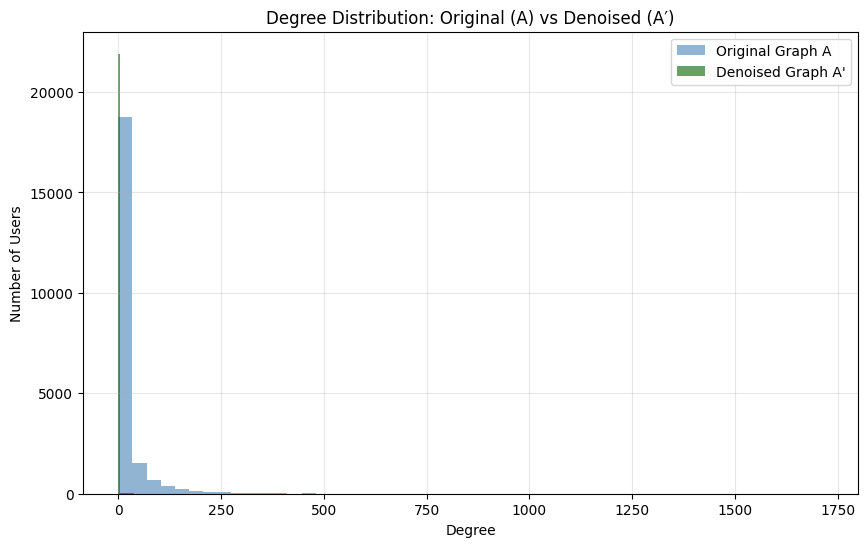

In [ ]:
# Step 3.12: Degree distribution comparison (EPINIONS-safe)

import matplotlib.pyplot as plt
import numpy as np

deg_A  = np.array(A.sum(1)).flatten()
deg_Ad = np.array(A_denoised.sum(1)).flatten()

plt.figure(figsize=(10,6))

plt.hist(deg_A,  bins=50, alpha=0.6, label="Original Graph A",  color="steelblue")
plt.hist(deg_Ad, bins=50, alpha=0.6, label="Denoised Graph A'", color="darkgreen")

plt.title("Degree Distribution: Original (A) vs Denoised (A′)")
plt.xlabel("Degree")
plt.ylabel("Number of Users")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [ ]:
import pandas as pd

# Convert ratings list (u, i, r) into DataFrame
ratings_df = pd.DataFrame(ratings, columns=["user", "item", "rating"])

# Normalize ratings to 0–1 range
min_rating = ratings_df["rating"].min()
max_rating = ratings_df["rating"].max()

ratings_df["rating_norm"] = (ratings_df["rating"] - min_rating) / (max_rating - min_rating)

print(ratings_df.head())


   user  item  rating  rating_norm
0     1     1     3.0     0.076923
1     1     2     2.0     0.038462
2     1     3     3.0     0.076923
3     1     4     3.0     0.076923
4     1     5     3.0     0.076923


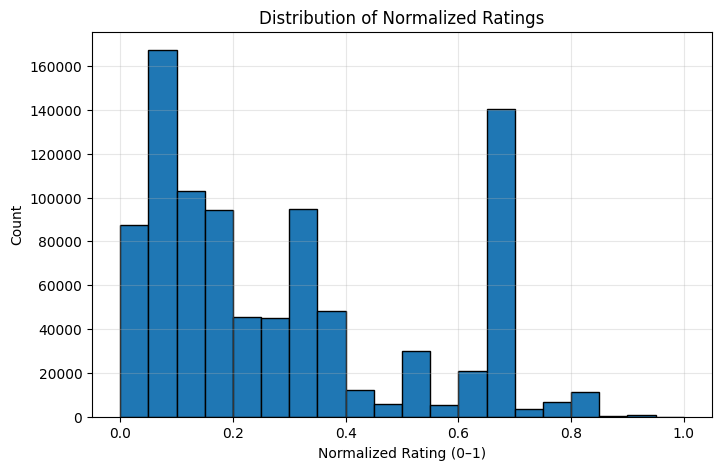

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(ratings_df["rating_norm"], bins=20, edgecolor="black")
plt.title("Distribution of Normalized Ratings")
plt.xlabel("Normalized Rating (0–1)")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


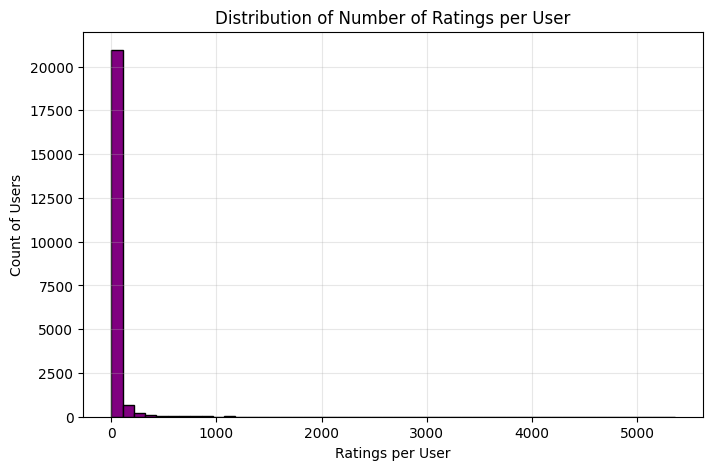

In [ ]:
# Step X: Distribution of number of ratings per user (EPINIONS-safe)

ratings_per_user = ratings_df.groupby("user").size()

plt.figure(figsize=(8,5))
plt.hist(ratings_per_user, bins=50, color="purple", edgecolor="black")
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Ratings per User")
plt.ylabel("Count of Users")
plt.grid(alpha=0.3)
plt.show()


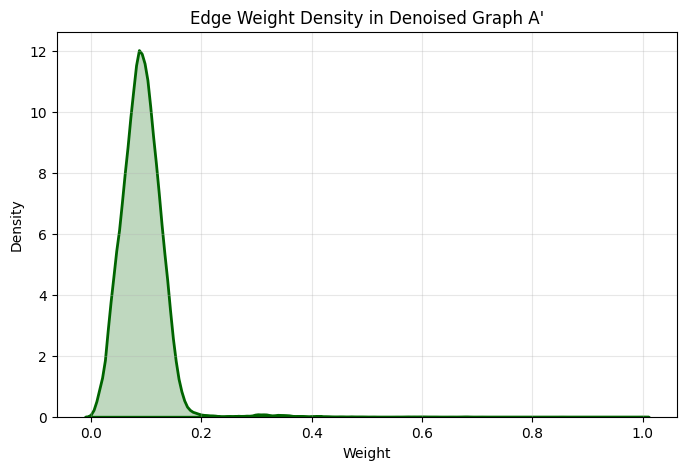

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step X: Density plot of denoised edge weights (EPINIONS-safe)

plt.figure(figsize=(8,5))
sns.kdeplot(A_denoised.data, fill=True, linewidth=2, color="darkgreen")
plt.title("Edge Weight Density in Denoised Graph A'")
plt.xlabel("Weight")
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Step 4: Normalize denoised adjacency A' (EPINIONS-safe) and convert to torch sparse

import scipy.sparse as sp

def fast_row_normalize(A):
    A = A.tocsr()
    rowsum = np.array(A.sum(1)).flatten()
    rowsum[rowsum == 0] = 1
    D_inv = 1.0 / rowsum
    return sp.diags(D_inv).dot(A)

A_denoised_norm = fast_row_normalize(A_denoised)

A_denoised_norm_torch = scipy_to_torch_sparse(A_denoised_norm).to(device)

print("A_denoised_norm_torch shape:", A_denoised_norm_torch.shape)


A_denoised_norm_torch shape: torch.Size([22164, 22164])


In [ ]:
# Step X: Build Train–Val–Test Splits for Ratings (EPINIONS-safe)

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# ---- FIX: Add user_idx and item_idx columns ----
ratings_df["user_idx"] = ratings_df["user"].map(user2idx).astype(int)
ratings_df["item_idx"] = ratings_df["item"].map(item2idx).astype(int)

# Check they now exist
print(ratings_df.head())

# ---- Create interaction array ----
interaction_array = ratings_df[["user_idx", "item_idx", "rating_norm"]].values

# ---- 80/10/10 split ----
train_inter, temp_inter = train_test_split(
    interaction_array, test_size=0.2, random_state=42
)
val_inter, test_inter = train_test_split(
    temp_inter, test_size=0.5, random_state=42
)

# ---- Build PyTorch loaders ----
def build_loader(array, batch_size=4096, shuffle=True):
    u = torch.from_numpy(array[:, 0].astype("int64"))
    i = torch.from_numpy(array[:, 1].astype("int64"))
    r = torch.from_numpy(array[:, 2].astype("float32"))
    dataset = TensorDataset(u, i, r)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = build_loader(train_inter, batch_size=4096, shuffle=True)
val_loader   = build_loader(val_inter,   batch_size=4096, shuffle=False)
test_loader  = build_loader(test_inter,  batch_size=4096, shuffle=False)

print("Train interactions:", len(train_inter))
print("Val interactions:", len(val_inter))
print("Test interactions:", len(test_inter))


   user  item  rating  rating_norm  user_idx  item_idx
0     1     1     3.0     0.076923         0         0
1     1     2     2.0     0.038462         0         1
2     1     3     3.0     0.076923         0         2
3     1     4     3.0     0.076923         0         3
4     1     5     3.0     0.076923         0         4
Train interactions: 737813
Val interactions: 92227
Test interactions: 92227


In [ ]:
import torch.nn.functional as F

class SocialGCN(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, adj, alpha=0.5, dropout_p=0.2):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_dim = emb_dim
        self.adj = adj        # torch sparse adjacency (normalized)
        self.alpha = alpha
        self.dropout_p = dropout_p

        # Bias terms
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        # User + Item Embeddings
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

        # GCN layers
        self.gc1 = GCNLayer(emb_dim, emb_dim)
        self.gc2 = GCNLayer(emb_dim, emb_dim)

    def propagate_users(self):
        h0 = self.user_emb.weight    # U0

        # Layer 1
        h1_nei = self.gc1(h0, self.adj)
        h1 = self.alpha * h0 + (1 - self.alpha) * h1_nei
        h1 = torch.relu(F.dropout(h1, p=self.dropout_p, training=self.training))

        # Layer 2
        h2_nei = self.gc2(h1, self.adj)
        h2 = self.alpha * h1 + (1 - self.alpha) * h2_nei
        h2 = F.dropout(h2, p=self.dropout_p, training=self.training)

        return h2

    def forward(self, user_idx, item_idx):
        user_z_all = self.propagate_users()
        u_z = user_z_all[user_idx]
        i_z = self.item_emb(item_idx)

        logits = (u_z * i_z).sum(dim=1)
        logits += self.user_bias(user_idx).squeeze(1)
        logits += self.item_bias(item_idx).squeeze(1)

        return logits, user_z_all


In [ ]:
# Step X: Initialize SocialGCN for EPINIONS

import torch.optim as optim

emb_dim = 64   # tunable
social_gcn = SocialGCN(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    adj=A_denoised_norm_torch,   # torch sparse adjacency A'
    alpha=0.6,
    dropout_p=0.25
).to(device)

gcn_optimizer = optim.Adam(social_gcn.parameters(), lr=0.005)
gcn_criterion = nn.MSELoss()   # rating_norm ∈ [0, 1]

print("SocialGCN initialized for EPINIONS.")


SocialGCN initialized for EPINIONS.


In [ ]:
# ============================================
# Step 4 (EPINIONS-safe): Train SocialGCN with multi-negative BPR + MSE
# ============================================

from collections import defaultdict
import torch
import torch.nn.functional as F
import numpy as np

# --------------------------------------------------
# 1) Build "seen" dictionary for negative sampling
# --------------------------------------------------
user_seen = defaultdict(set)

for u, i, r in train_inter:
    user_seen[int(u)].add(int(i))

for u, i, r in val_inter:
    user_seen[int(u)].add(int(i))

all_items = np.arange(num_items)

def sample_negatives(u, n_neg=5):
    seen = user_seen[u]
    negs = []
    while len(negs) < n_neg:
        j = int(np.random.randint(0, num_items))
        if j not in seen:
            negs.append(j)
    return negs


# --------------------------------------------------
# Multi-negative BPR
# --------------------------------------------------
def multi_bpr_loss(pos_logits, neg_logits):
    diff = pos_logits.unsqueeze(1) - neg_logits
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()


# --------------------------------------------------
# One training epoch
# --------------------------------------------------
def run_train_epoch_multi_bpr(model, loader, optimizer, n_neg=5, mse_lambda=0.1):
    model.train()
    total_loss = 0.0
    total_count = 0

    for u, i_pos, r_batch in loader:
        u = u.to(device)
        i_pos = i_pos.to(device)
        r_batch = r_batch.to(device)

        # Negative items
        neg_items = [sample_negatives(int(x), n_neg=n_neg) for x in u.cpu().numpy()]
        i_neg = torch.tensor(neg_items, dtype=torch.long, device=device)

        optimizer.zero_grad()

        # Positive logits
        pos_logits, _ = model(u, i_pos)

        # Negative logits
        B, nN = i_neg.shape
        u_rep = u.unsqueeze(1).expand(B, nN).reshape(-1)
        i_neg_flat = i_neg.reshape(-1)

        neg_logits_flat, _ = model(u_rep, i_neg_flat)
        neg_logits = neg_logits_flat.reshape(B, nN)

        # Hybrid loss: BPR + MSE
        bpr = multi_bpr_loss(pos_logits, neg_logits)
        preds_pos = torch.sigmoid(pos_logits)
        mse = F.mse_loss(preds_pos, r_batch)

        loss = bpr + mse_lambda * mse
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(u)
        total_count += len(u)

    return total_loss / total_count


# --------------------------------------------------
# 2) Train loop
# --------------------------------------------------
num_epochs_gnn = 20
n_neg = 5
mse_lambda = 0.1

for epoch in range(1, num_epochs_gnn + 1):
    train_loss = run_train_epoch_multi_bpr(
        social_gcn,
        train_loader,
        gcn_optimizer,
        n_neg=n_neg,
        mse_lambda=mse_lambda
    )
    print(f"[Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("Step 4: SocialGCN BPR training complete.")


[Epoch 01] train_loss = 0.6039
[Epoch 02] train_loss = 0.4557
[Epoch 03] train_loss = 0.3865
[Epoch 04] train_loss = 0.3354
[Epoch 05] train_loss = 0.2837
[Epoch 06] train_loss = 0.2337
[Epoch 07] train_loss = 0.1930
[Epoch 08] train_loss = 0.1630
[Epoch 09] train_loss = 0.1396
[Epoch 10] train_loss = 0.1221
[Epoch 11] train_loss = 0.1083
[Epoch 12] train_loss = 0.0973
[Epoch 13] train_loss = 0.0884
[Epoch 14] train_loss = 0.0811
[Epoch 15] train_loss = 0.0752
[Epoch 16] train_loss = 0.0701
[Epoch 17] train_loss = 0.0659
[Epoch 18] train_loss = 0.0622
[Epoch 19] train_loss = 0.0590
[Epoch 20] train_loss = 0.0563
Step 4: SocialGCN BPR training complete.


In [ ]:
# Step X: Validation positive-interaction statistics (EPINIONS-safe)

import numpy as np

thresh = 0.5  # rating_norm >= 0.5 == positive

val_pos = val_inter[val_inter[:, 2] >= thresh]

print("Total val interactions:", len(val_inter))
print("Val positives (>=0.5):", len(val_pos))
print("Users with ≥1 positive in val:", len(np.unique(val_pos[:, 0])))

# average number of positives per user in validation set
users = np.unique(val_inter[:, 0])
avg_pos = np.mean([
    np.sum((val_inter[:, 0] == u) & (val_inter[:, 2] >= thresh))
    for u in users
])

print("Avg positives per user in val:", avg_pos)


Total val interactions: 92227
Val positives (>=0.5): 22007
Users with ≥1 positive in val: 8247
Avg positives per user in val: 1.161441840827528


In [ ]:
# Step X: Extract User and Item Embeddings (EPINIONS-safe)

social_gcn.eval()
with torch.no_grad():
    user_embeddings = social_gcn.propagate_users().cpu().numpy()      # [num_users, emb_dim]
    item_embeddings = social_gcn.item_emb.weight.detach().cpu().numpy()  # [num_items, emb_dim]

print("User embeddings shape:", user_embeddings.shape)
print("Item embeddings shape:", item_embeddings.shape)


User embeddings shape: (22164, 64)
Item embeddings shape: (296277, 64)


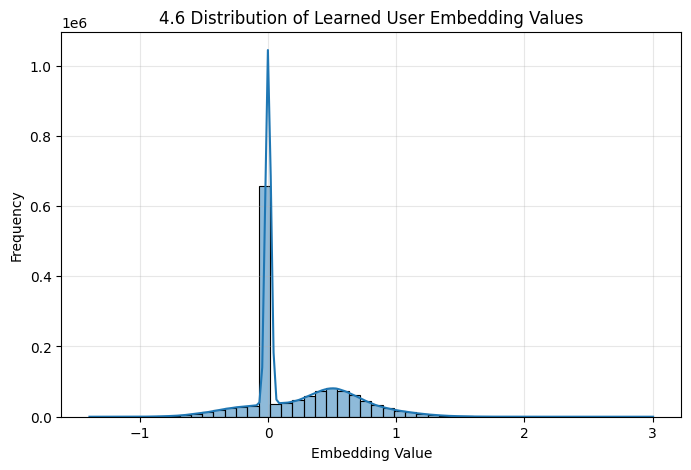

In [ ]:
#Distribution of User Embedding Values
flat = user_embeddings.flatten()

plt.figure(figsize=(8,5))
sns.histplot(flat, bins=50, kde=True)
plt.title("4.6 Distribution of Learned User Embedding Values")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


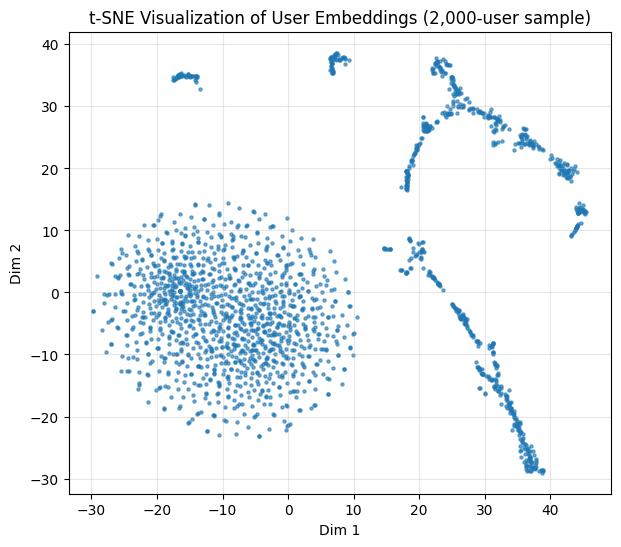

In [ ]:
# Step X: t-SNE Visualization of User Embeddings (EPINIONS-safe, subsampled)

from sklearn.manifold import TSNE
import numpy as np

# ---- Subsample users (e.g., 2000 random users) ----
num_samples = 2000
idx = np.random.choice(user_embeddings.shape[0], num_samples, replace=False)
user_emb_sample = user_embeddings[idx]

# ---- Run t-SNE on subsample ----
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    n_iter=1500,
    random_state=42
)

emb_2d = tsne.fit_transform(user_emb_sample)

# ---- Plot ----
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.6)
plt.title("t-SNE Visualization of User Embeddings (2,000-user sample)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(alpha=0.3)
plt.show()


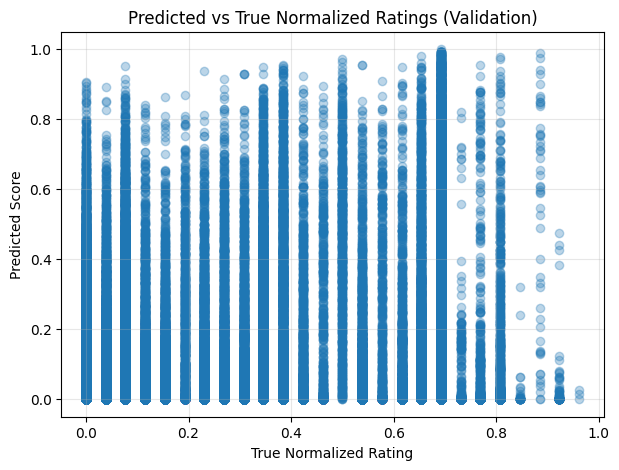

In [ ]:
# Step X: Predicted vs True Ratings (Calibration Plot) - EPINIONS-safe

all_preds, all_true = [], []

social_gcn.eval()
with torch.no_grad():
    for u, i, r in val_loader:
        u = u.to(device)
        i = i.to(device)

        scores, _ = social_gcn(u, i)
        preds = torch.sigmoid(scores).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(r.cpu().numpy())   # <-- safe CPU access

plt.figure(figsize=(7,5))
plt.scatter(all_true, all_preds, alpha=0.3)
plt.title("Predicted vs True Normalized Ratings (Validation)")
plt.xlabel("True Normalized Rating")
plt.ylabel("Predicted Score")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Step 5: Recommendation Modeling (Link Prediction) - EPINIONS-safe

import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def get_user_scores(u_idx: int):
    """
    Compute predicted scores in [0,1] for ALL items for the given user.
    Uses the embeddings learned by SocialGCN (Step 4).
    """
    u_vec = user_embeddings[u_idx]                     # (emb_dim,)
    raw_scores = item_embeddings @ u_vec               # (num_items,)
    scores = sigmoid(raw_scores)                       # normalize to [0,1]
    return scores

def recommend_for_user(u_idx: int, top_k: int = 10, exclude_seen: bool = True):
    """
    Recommend top_k items for a given user, with optional exclusion of
    already-rated items.
    """
    scores = get_user_scores(u_idx)
    num_items = item_embeddings.shape[0]
    all_items = np.arange(num_items)

    if exclude_seen:
        seen_items = ratings_df.loc[
            ratings_df["user_idx"] == u_idx, "item_idx"
        ].values
        mask = np.ones(num_items, dtype=bool)
        mask[seen_items] = False
        candidate_items = all_items[mask]
        candidate_scores = scores[mask]
    else:
        candidate_items = all_items
        candidate_scores = scores

    order = np.argsort(-candidate_scores)
    top_items = candidate_items[order[:top_k]]
    top_scores = candidate_scores[order[:top_k]]

    return list(zip(top_items, top_scores))


# --- Example: Recommend for 3 random users that exist in EPINIONS ---

example_users = np.random.choice(num_users, size=3, replace=False)

for u in example_users:
    recs = recommend_for_user(int(u), top_k=10, exclude_seen=True)
    print(f"\nTop-10 recommendations for user_idx {u}:")
    for item_idx, score in recs:
        print(f"  item_idx {item_idx:6d}  |  predicted score = {score:.4f}")



Top-10 recommendations for user_idx 14685:
  item_idx   7331  |  predicted score = 0.9524
  item_idx  25861  |  predicted score = 0.9470
  item_idx     79  |  predicted score = 0.9423
  item_idx    294  |  predicted score = 0.9402
  item_idx   7963  |  predicted score = 0.9400
  item_idx  41136  |  predicted score = 0.9351
  item_idx   3889  |  predicted score = 0.9346
  item_idx   8429  |  predicted score = 0.9321
  item_idx    107  |  predicted score = 0.9317
  item_idx    476  |  predicted score = 0.9295

Top-10 recommendations for user_idx 11242:
  item_idx   3678  |  predicted score = 0.9548
  item_idx   9435  |  predicted score = 0.9463
  item_idx     79  |  predicted score = 0.9440
  item_idx  38434  |  predicted score = 0.9417
  item_idx  10733  |  predicted score = 0.9415
  item_idx  10480  |  predicted score = 0.9396
  item_idx   8922  |  predicted score = 0.9379
  item_idx   8896  |  predicted score = 0.9299
  item_idx    480  |  predicted score = 0.9265
  item_idx  27072  

Plotting for user_idx = 1361


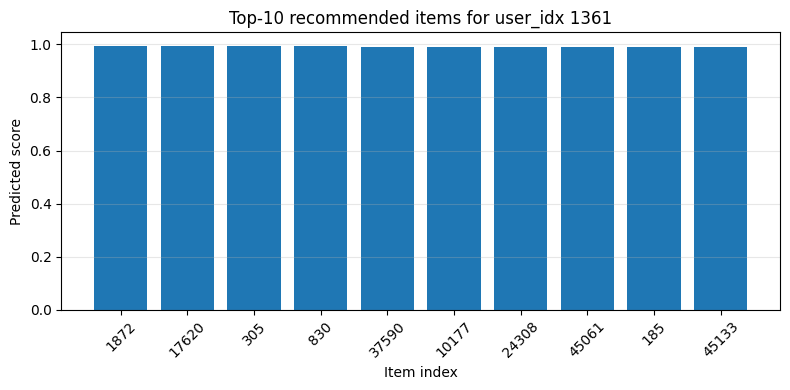

In [ ]:
# Step X: Bar plot of Top-K Recommendations (EPINIONS-safe)

import matplotlib.pyplot as plt

def plot_user_topk(u_idx: int, top_k: int = 10):
    """
    Bar plot of predicted scores for top-k recommended items for user u_idx.
    """
    recs = recommend_for_user(u_idx, top_k=top_k, exclude_seen=True)

    if len(recs) == 0:
        print(f"user_idx {u_idx} has no unseen items — skipping.")
        return

    item_ids = [i for (i, s) in recs]
    scores = [s for (i, s) in recs]

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(item_ids)), scores)
    plt.xticks(range(len(item_ids)), item_ids, rotation=45)
    plt.xlabel("Item index")
    plt.ylabel("Predicted score")
    plt.title(f"Top-{top_k} recommended items for user_idx {u_idx}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# --- Choose a safe example user (one with ≥1 rating) ---
valid_users = ratings_df["user_idx"].unique()
example_user = int(np.random.choice(valid_users))

print("Plotting for user_idx =", example_user)
plot_user_topk(example_user, top_k=10)


In [ ]:
# Step X: Tabulate Top-K Recommendations (EPINIONS-safe)

import pandas as pd
import numpy as np

def tabulate_recommendations(u_idx: int, top_k: int = 10):
    recs = recommend_for_user(u_idx, top_k=top_k, exclude_seen=True)

    df = pd.DataFrame(recs, columns=["item_idx", "predicted_score"])
    df["rank"] = np.arange(1, len(df) + 1)

    # Optional item ID mapping (if exists)
    if "idx2item" in globals():
        df["raw_item_id"] = df["item_idx"].map(idx2item)

    # Mark whether any recommended item was already rated (should be False)
    seen_items = set(ratings_df.loc[ratings_df["user_idx"] == u_idx, "item_idx"].values)
    df["already_rated"] = df["item_idx"].isin(seen_items)

    return df[
        ["rank", "item_idx"]
        + (["raw_item_id"] if "idx2item" in globals() else [])
        + ["predicted_score", "already_rated"]
    ]

# Pick a valid user who has interactions
valid_users = ratings_df["user_idx"].unique()
example_user = int(np.random.choice(valid_users))

tab_df = tabulate_recommendations(example_user, top_k=20)
tab_df


,rank,item_idx,predicted_score,already_rated
0,1,7331,0.949939,False
1,2,833,0.947504,False
2,3,10480,0.931096,False
3,4,10653,0.921677,False
4,5,223,0.921497,False
5,6,3678,0.920249,False
6,7,5075,0.920083,False
7,8,932,0.918805,False
8,9,3887,0.916225,False
9,10,10793,0.916015,False


Unique recommended items: 1121 out of 3000


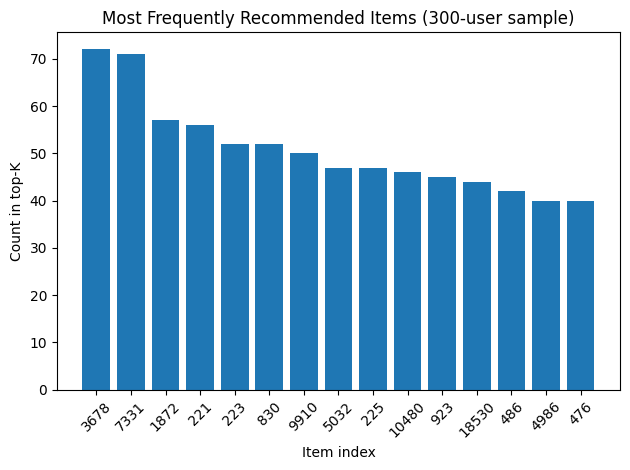

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def collect_topk_for_users(user_list, top_k=10):
    counter = Counter()
    for u in user_list:
        recs = recommend_for_user(int(u), top_k=top_k, exclude_seen=True)
        counter.update([i for i, s in recs])
    return counter

# ---- FIX: Sample only users who have interactions ----
valid_users = ratings_df["user_idx"].unique()
user_sample = np.random.choice(valid_users, size=300, replace=False)

# ---- Collect Top-K item frequencies ----
item_counter = collect_topk_for_users(user_sample, top_k=10)

unique_items = len(item_counter)
total_recs = len(user_sample) * 10

print("Unique recommended items:", unique_items, "out of", total_recs)

# ---- Plot the top-15 most frequently recommended items ----
top_items = item_counter.most_common(15)
labels = [str(i) for i, c in top_items]
counts = [c for i, c in top_items]

plt.figure()
plt.bar(labels, counts)
plt.xlabel("Item index")
plt.ylabel("Count in top-K")
plt.title("Most Frequently Recommended Items (300-user sample)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


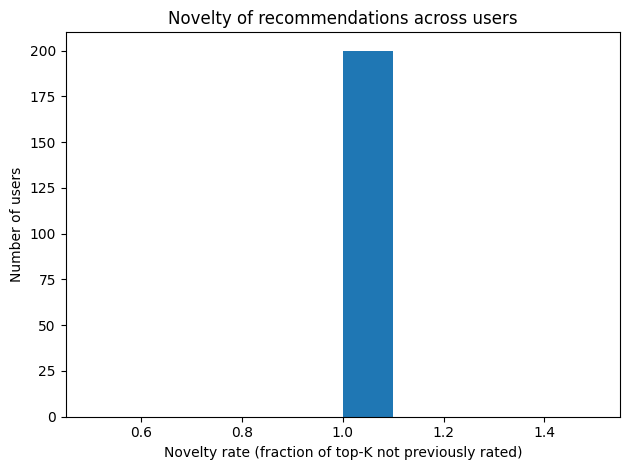

Average novelty rate: 1.0


In [ ]:
# Step X: Novelty rate (EPINIONS-safe)

import numpy as np
import matplotlib.pyplot as plt

def novelty_rate_for_user(u_idx, top_k=10):
    recs = recommend_for_user(int(u_idx), top_k=top_k, exclude_seen=True)
    rec_items = {i for i, s in recs}
    seen_items = set(ratings_df.loc[ratings_df["user_idx"] == u_idx, "item_idx"].values)
    return 1.0 - len(rec_items & seen_items) / top_k

# EPINIONS-safe: sample only users who have interactions
valid_users = ratings_df["user_idx"].unique()
user_sample = np.random.choice(valid_users, size=200, replace=False)

novelty_rates = [novelty_rate_for_user(u, top_k=10) for u in user_sample]

plt.figure()
plt.hist(novelty_rates, bins=10)
plt.xlabel("Novelty rate (fraction of top-K not previously rated)")
plt.ylabel("Number of users")
plt.title("Novelty of recommendations across users")
plt.tight_layout()
plt.show()

print("Average novelty rate:", np.mean(novelty_rates))


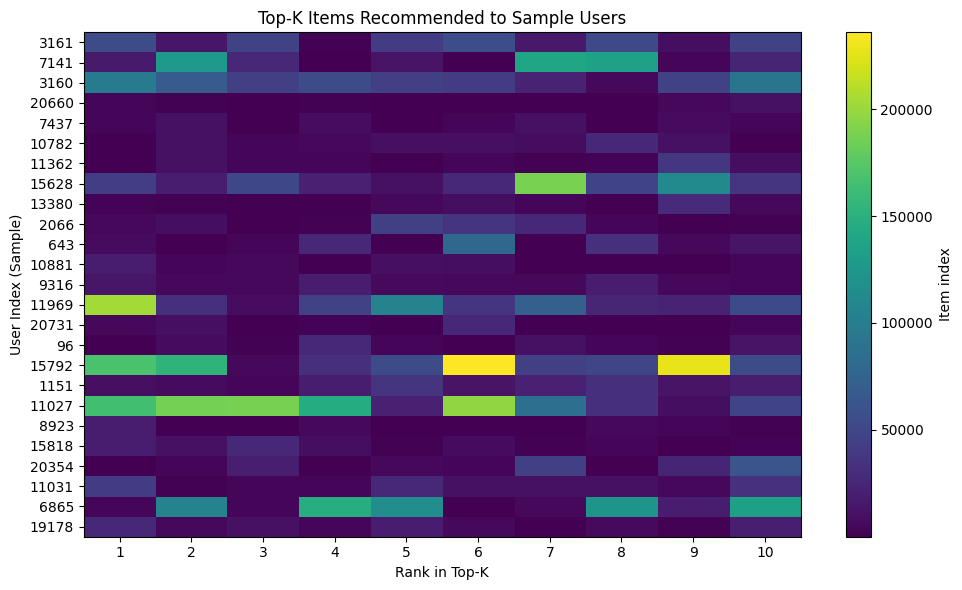

In [ ]:
# Step X: Heatmap of Top-K Recommended Items (EPINIONS-safe)

import numpy as np
import matplotlib.pyplot as plt

# ---- Sample only users who have at least 1 rating ----
valid_users = ratings_df["user_idx"].unique()
user_sample = np.random.choice(valid_users, size=25, replace=False)

top_k = 10
heat_items = []

for u in user_sample:
    recs = recommend_for_user(int(u), top_k=top_k, exclude_seen=True)
    heat_items.append([i for i, s in recs])

heat_items = np.array(heat_items)  # shape [25, 10]

plt.figure(figsize=(10, 6))
plt.imshow(heat_items, aspect="auto", cmap="viridis")
plt.colorbar(label="Item index")
plt.yticks(range(len(user_sample)), user_sample)
plt.xticks(range(top_k), range(1, top_k+1))
plt.xlabel("Rank in Top-K")
plt.ylabel("User Index (Sample)")
plt.title("Top-K Items Recommended to Sample Users")
plt.tight_layout()
plt.show()


In [ ]:
# Step X: Items with highest embedding norms (EPINIONS-safe)

# L2 norm of each item embedding
norms = np.linalg.norm(item_embeddings, axis=1)

# indices of top-10 items with largest norm
top_norm_items = norms.argsort()[-10:][::-1]

top_norm_items


array([180192, 173320, 209445, 202877, 283488, 170875, 122245, 183757,
       112611,  34512])

In [ ]:
# Step X: Recompute User & Item Embeddings (EPINIONS-safe)

social_gcn.eval()
with torch.no_grad():
    user_embeddings = social_gcn.propagate_users().cpu().numpy()
    item_embeddings = social_gcn.item_emb.weight.detach().cpu().numpy()

print("user_embeddings:", user_embeddings.shape)
print("item_embeddings:", item_embeddings.shape)


user_embeddings: (22164, 64)
item_embeddings: (296277, 64)


In [ ]:
# Step X: Average User–User Cosine Similarity (EPINIONS-safe)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# sample only users who have at least 1 rating
valid_users = ratings_df["user_idx"].unique()
sample_users = np.random.choice(valid_users, size=300, replace=False)

# compute cosine similarity on sample
sim = cosine_similarity(user_embeddings[sample_users])

avg_cos = sim[np.triu_indices_from(sim, 1)].mean()
print("Average user-user cosine similarity:", avg_cos)


Average user-user cosine similarity: 0.248257


In [ ]:
# Step X: Personalization via Jaccard Similarity (EPINIONS-safe)

import numpy as np

def personalization_score(user_list, top_k=10):
    topk_lists = []
    for u in user_list:
        recs = recommend_for_user(int(u), top_k=top_k, exclude_seen=True)
        topk_lists.append(set([i for i, s in recs]))

    # average pairwise Jaccard similarity
    sims = []
    for a in range(len(topk_lists)):
        for b in range(a + 1, len(topk_lists)):
            inter = len(topk_lists[a] & topk_lists[b])
            union = len(topk_lists[a] | topk_lists[b])
            sims.append(inter / union if union > 0 else 0)

    return float(np.mean(sims))

# ---- EPINIONS FIX: sample only valid users with interactions ----
valid_users = ratings_df["user_idx"].unique()
user_sample = np.random.choice(valid_users, size=80, replace=False)

jac_sim = personalization_score(user_sample, top_k=10)
print("Avg Jaccard similarity across users’ top-10:", jac_sim)
print("Personalization (1 - Jaccard):", 1 - jac_sim)


Avg Jaccard similarity across users’ top-10: 0.0504046073835332
Personalization (1 - Jaccard): 0.9495953926164667


In [ ]:
# Step X: Coverage metric (EPINIONS-safe)

from collections import Counter
import numpy as np

def coverage(user_list, top_k=10):
    counter = Counter()
    for u in user_list:
        recs = recommend_for_user(int(u), top_k=top_k, exclude_seen=True)
        counter.update([i for i, s in recs])
    unique_items = len(counter)
    return unique_items, counter

# ---- EPINIONS FIX: sample only valid users ----
valid_users = ratings_df["user_idx"].unique()
user_sample = np.random.choice(valid_users, size=300, replace=False)

unique_items, item_counter = coverage(user_sample, top_k=10)

print("Unique recommended items:", unique_items)
print("Total possible items:", num_items)
print("Coverage ratio:", unique_items / num_items)
print("Top-10 most frequent recommended items:", item_counter.most_common(10))


Unique recommended items: 1064
Total possible items: 296277
Coverage ratio: 0.0035912338791063768
Top-10 most frequent recommended items: [(np.int64(3678), 81), (np.int64(7331), 74), (np.int64(1872), 60), (np.int64(223), 58), (np.int64(9910), 51), (np.int64(225), 51), (np.int64(18530), 46), (np.int64(1863), 46), (np.int64(486), 45), (np.int64(221), 45)]


In [ ]:
# Step X: Evaluation-Time Recommender (EPINIONS-safe)

from collections import defaultdict
import numpy as np

# ---------------------------------------------------------
# Build "seen" dictionary from TRAIN (+ optional VAL)
# ---------------------------------------------------------
user_seen_train = defaultdict(set)

# TRAIN ONLY (primary evaluation)
for u, i, r in train_inter:
    user_seen_train[int(u)].add(int(i))

# Optional: also exclude VAL interactions
for u, i, r in val_inter:
    user_seen_train[int(u)].add(int(i))


# ---------------------------------------------------------
# Evaluation Recommender
# Excludes only TRAIN (+VAL) but NOT TEST
# ---------------------------------------------------------
def recommend_for_user_eval(u_idx: int, top_k: int = 10):
    """
    Evaluation recommender:
    - Uses learned embeddings
    - Excludes only train(+val) items
    - Test interactions remain untouched for metric computation
    """
    scores = get_user_scores(int(u_idx))          # Step-5 scoring function
    num_items = len(scores)

    seen = user_seen_train.get(int(u_idx), set())

    # filter: keep only unseen items
    candidates = [(i, scores[i]) for i in range(num_items) if i not in seen]

    # sort by predicted score
    candidates.sort(key=lambda x: x[1], reverse=True)

    return candidates[:top_k]


In [ ]:
import numpy as np
from collections import defaultdict

# ---------------------------------------------------------
# Evaluation-time recommendation helper
# ---------------------------------------------------------
def recommend_for_user_eval(u_idx, seen_dict, top_k=10):
    """
    Evaluation recommender:
    - Uses learned embeddings via get_user_scores()
    - Excludes only items in seen_dict[u_idx]
    - Does NOT exclude test items
    - Returns top-k item indices
    """
    u_idx = int(u_idx)
    scores = get_user_scores(u_idx)
    seen = seen_dict.get(u_idx, set())

    # Filter only unseen items
    candidates = [(i, float(scores[i])) for i in range(len(scores)) if i not in seen]
    candidates.sort(key=lambda x: x[1], reverse=True)

    return [i for (i, s) in candidates[:top_k]]


# ---------------------------------------------------------
# Metrics: Precision@K, Recall@K, nDCG@K
# ---------------------------------------------------------
def precision_at_k(recommended, relevant, k):
    if k == 0:
        return 0.0
    return len(set(recommended[:k]) & relevant) / k

def recall_at_k(recommended, relevant, k):
    if len(relevant) == 0:
        return 0.0
    return len(set(recommended[:k]) & relevant) / len(relevant)

def ndcg_at_k(recommended, relevant, k):
    rec_k = recommended[:k]
    gains = [1.0 if i in relevant else 0.0 for i in rec_k]
    dcg = sum(g / np.log2(idx + 2) for idx, g in enumerate(gains))
    ideal = sorted(gains, reverse=True)
    idcg = sum(g / np.log2(idx + 2) for idx, g in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0


# ---------------------------------------------------------
# Complete evaluation routine
# ---------------------------------------------------------
def evaluate_split(interactions, seen_dict, k=10, rating_thresh=0.5, max_users=500):
    """
    interactions: array of (user_idx, item_idx, rating_norm)
    seen_dict: dictionary with items to exclude (train-only for val; train+val for test)
    """
    user_to_relevant = defaultdict(set)

    # Build set of relevant (positive) items per user
    for u, i, r in interactions:
        u = int(u); i = int(i); r = float(r)
        if r >= rating_thresh:
            user_to_relevant[u].add(i)

    # EPINIONS FIX: Only evaluate users who exist in ratings_df
    valid_users = ratings_df["user_idx"].unique().tolist()
    users = [u for u in user_to_relevant.keys() if u in valid_users]

    # Optional: subsample to speed up evaluation
    if max_users and len(users) > max_users:
        users = users[:max_users]

    precisions, recalls, ndcgs = [], [], []

    for u in users:
        relevant = user_to_relevant[u]
        if not relevant:
            continue

        rec_items = recommend_for_user_eval(int(u), seen_dict, top_k=k)

        precisions.append(precision_at_k(rec_items, relevant, k))
        recalls.append(recall_at_k(rec_items, relevant, k))
        ndcgs.append(ndcg_at_k(rec_items, relevant, k))

    return (
        float(np.mean(precisions)),
        float(np.mean(recalls)),
        float(np.mean(ndcgs))
    )


In [ ]:
from collections import defaultdict

# ---------------------------------------------------------
# Build seen dictionaries
# ---------------------------------------------------------

# seen only from TRAIN → used for VALIDATION
seen_train = defaultdict(set)
for u, i, r in train_inter:
    seen_train[int(u)].add(int(i))

# seen from TRAIN + VAL → used for TEST
seen_trainval = defaultdict(set)
for u, i, r in train_inter:
    seen_trainval[int(u)].add(int(i))
for u, i, r in val_inter:
    seen_trainval[int(u)].add(int(i))


# ---------------------------------------------------------
# Evaluate at K = 10
# ---------------------------------------------------------
K = 10

print("=== Validation metrics (exclude only train items) ===")
p_val, r_val, ndcg_val = evaluate_split(
    val_inter,
    seen_train,
    k=K,
    rating_thresh=0.5,
    max_users=500
)
print(f"Val Precision@{K}: {p_val:.4f}")
print(f"Val Recall@{K}:    {r_val:.4f}")
print(f"Val nDCG@{K}:      {ndcg_val:.4f}")

print("\n=== Test metrics (exclude train + val items) ===")
p_test, r_test, ndcg_test = evaluate_split(
    test_inter,
    seen_trainval,
    k=K,
    rating_thresh=0.5,
    max_users=500
)
print(f"Test Precision@{K}: {p_test:.4f}")
print(f"Test Recall@{K}:    {r_test:.4f}")
print(f"Test nDCG@{K}:      {ndcg_test:.4f}")


=== Validation metrics (exclude only train items) ===
Val Precision@10: 0.0026
Val Recall@10:    0.0092
Val nDCG@10:      0.0126

=== Test metrics (exclude train + val items) ===
Test Precision@10: 0.0036
Test Recall@10:    0.0145
Test nDCG@10:      0.0151


# ===============================================
# Phase 3 — Step 1: Implement Explainability Layer
# ===============================================

This section replaces GCN propagation with Graph Attention Networks (GAT)
to enable explainability through learned social influence weights.
It also adds SHAP-based feature-level explanations.


In [ ]:
# Step X: Convert SciPy sparse adjacency matrices to Torch sparse (EPINIONS-safe)

def scipy_to_torch_sparse(mat):
    mat = mat.tocoo()
    indices = torch.from_numpy(
        np.vstack([mat.row, mat.col]).astype(np.int64)
    )
    values = torch.from_numpy(mat.data.astype(np.float32))
    shape = torch.Size(mat.shape)
    return torch.sparse_coo_tensor(indices, values, shape).coalesce()

# A' (denoised)
A_denoised_torch = scipy_to_torch_sparse(A_denoised).to(device)

# A (raw original)
A_raw_torch = scipy_to_torch_sparse(A).to(device)

print("A_denoised_torch:", A_denoised_torch.shape, "nnz =", A_denoised_torch._nnz())
print("A_raw_torch:", A_raw_torch.shape, "nnz =", A_raw_torch._nnz())


A_denoised_torch: torch.Size([22164, 22164]) nnz = 168986
A_raw_torch: torch.Size([22164, 22164]) nnz = 469877


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.2, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.attn_l = nn.Parameter(torch.empty(out_dim, 1))
        self.attn_r = nn.Parameter(torch.empty(out_dim, 1))
        nn.init.xavier_uniform_(self.attn_l)
        nn.init.xavier_uniform_(self.attn_r)

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj_sparse):
        """
        x: [N, in_dim]
        adj_sparse: torch.sparse_coo_tensor with shape [N, N]
        Computes attention only on non-zero edges.
        """
        N = x.size(0)

        # Linear transform
        h = self.W(x)   # [N, out_dim]

        # Extract indices from sparse adjacency
        idx = adj_sparse.coalesce().indices()   # shape [2, E]
        row = idx[0]    # source nodes
        col = idx[1]    # target nodes

        # Compute attention scores e_ij = a(Wh_i || Wh_j)
        h_row = h[row]  # [E, out_dim]
        h_col = h[col]  # [E, out_dim]

        # Compute attention contribution from source & target
        e = self.leakyrelu(
            (h_row @ self.attn_l).squeeze(-1) +
            (h_col @ self.attn_r).squeeze(-1)
        )  # [E]

        # Softmax over edges per node
        att = torch.exp(e)
        # sum per source node
        att_sum = torch.zeros(N, device=x.device).index_add_(0, row, att)
        att_norm = att / (att_sum[row] + 1e-9)

        att_norm = self.dropout(att_norm)

        # Message passing: weighted neighbor aggregation
        out = torch.zeros_like(h)
        out.index_add_(0, row, h_col * att_norm.unsqueeze(-1))

        return out, att_norm


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ExplainableSocialGAT(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, dropout=0.2, alpha=0.2):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items

        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        # Sparse, scalable GAT layer (EPINIONS-safe)
        self.gat_layer = SparseGATLayer(
            in_dim=emb_dim,
            out_dim=emb_dim,
            dropout=dropout,
            alpha=alpha
        )

        # initialize embeddings
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

    def propagate_users(self, A_sparse):
        """
        A_sparse: torch.sparse_coo_tensor of shape [N, N]
        Returns:
            user embeddings after GAT,
            attention weights (one per edge)
        """
        user_vecs = self.user_emb.weight  # [N, d]
        out, attn = self.gat_layer(user_vecs, A_sparse)
        return out, attn

    def forward(self, users, items, A_sparse):
        """
        users: LongTensor [batch]
        items: LongTensor [batch]
        A_sparse: sparse adjacency
        """
        user_z, attn = self.propagate_users(A_sparse)
        u = user_z[users]                 # [batch, d]
        i = self.item_emb(items)          # [batch, d]
        scores = (u * i).sum(dim=1)
        return scores, attn


In [ ]:
# Use the same embedding dimension as SocialGCN
emb_dim = 64

# Initialize the Explainable Social GAT model (with sparse attention)
explain_model = ExplainableSocialGAT(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim
).to(device)

print("ExplainableSocialGAT initialized.")


ExplainableSocialGAT initialized.


In [ ]:
explain_model.eval()

with torch.no_grad():
    user_embeddings_out, attention_weights = explain_model.propagate_users(A_denoised_torch)

print("User embeddings shape:", user_embeddings_out.shape)
print("Attention weights shape (one per edge):", attention_weights.shape)
print("Number of edges in A':", A_denoised_torch._nnz())


User embeddings shape: torch.Size([22164, 64])
Attention weights shape (one per edge): torch.Size([168986])
Number of edges in A': 168986


In [ ]:
def explain_social_influence(user_id, attn, A_sparse, top_k=5):
    """
    Returns the top-K most influential neighbors for user_id
    based on sparse attention weights.

    attn: tensor of shape [E] from SparseGATLayer
    A_sparse: torch.sparse adjacency (COO)
    """
    # Get edge list
    idx = A_sparse.coalesce().indices()   # [2, E]
    rows = idx[0]    # source users
    cols = idx[1]    # target neighbors

    # Find edges that originate from this user
    mask = (rows == user_id)
    if mask.sum() == 0:
        return [], []

    neighbor_ids = cols[mask].cpu().numpy()        # neighbor user IDs
    neighbor_weights = attn[mask].detach().cpu().numpy()

    # Top-K neighbors by attention weight
    order = neighbor_weights.argsort()[::-1][:top_k]

    top_neighbors = neighbor_ids[order]
    top_weights = neighbor_weights[order]

    return top_neighbors, top_weights


In [ ]:
import shap
import numpy as np
import torch

def shap_explain_user(user_id, item_id, model, A_sparse):
    dev = next(model.parameters()).device

    with torch.no_grad():
        user_z, _ = model.propagate_users(A_sparse)
        u = user_z[user_id].detach().cpu().numpy()
        i = model.item_emb(torch.tensor([item_id], device=dev)).detach().cpu().numpy().reshape(-1)

    def predict(u_emb):
        return np.dot(u_emb, i)

    background = np.zeros_like(u).reshape(1, -1)
    explainer = shap.KernelExplainer(predict, background)
    shap_vals = explainer.shap_values(u.reshape(1, -1))
    return shap_vals


In [ ]:
def explain_recommendation(user_id, item_id, model, A_sparse, attention_vec, top_k_social=5):
    """
    Produce an explanation for why a recommendation (user -> item) was made.

    Explanation pieces:
      1. Top social influencers (neighbors with highest attention)
      2. User-item embedding interaction score
    """
    # -----------------------------
    # 1. Top social influencers
    # -----------------------------
    top_neighbors, top_weights = explain_social_influence(
        user_id=user_id,
        attn=attention_vec,
        A_sparse=A_sparse,
        top_k=top_k_social
    )

    social_msgs = [
        f"Friend {n} influenced this recommendation with attention weight {w:.4f}"
        for n, w in zip(top_neighbors, top_weights)
    ]

    # -----------------------------
    # 2. User-item embedding interaction score
    # -----------------------------
    with torch.no_grad():
        user_z, _ = model.propagate_users(A_sparse)
        u_vec = user_z[user_id]
        i_vec = model.item_emb(torch.tensor([item_id], device=u_vec.device)).squeeze(0)
        dot_score = float(torch.dot(u_vec, i_vec).cpu())

    interaction_msg = f"User-item embedding dot score: {dot_score:.4f}"

    return {
        "social_explanations": social_msgs,
        "interaction_explanation": interaction_msg
    }


In [ ]:
explain_model.eval()

with torch.no_grad():
    scores, attn = explain_model.forward(
        users=torch.tensor([0], device=device, dtype=torch.long),
        items=torch.tensor([10], device=device, dtype=torch.long),
        A_sparse=A_denoised_torch     # <-- correct argument name
    )

print("Score:", scores.item())
print("Attention shape:", attn.shape)
print("Number of edges (A'):", A_denoised_torch._nnz())


Score: 5.06162759847939e-05
Attention shape: torch.Size([168986])
Number of edges (A'): 168986


In [ ]:
u = 5

with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)

# edge list from sparse matrix
idx = A_denoised_torch.coalesce().indices()   # [2, E]
rows = idx[0]   # sources
cols = idx[1]   # targets

# mask edges where source == user u
mask = (rows == u)

if mask.sum() == 0:
    print("User", u, "has no neighbors in A'")
else:
    neighbor_ids = cols[mask].cpu().numpy()
    neighbor_weights = attn[mask].detach().cpu().numpy()

    # top 5 neighbors
    order = neighbor_weights.argsort()[::-1][:5]
    print("Neighbors:", neighbor_ids[order])
    print("Weights:", neighbor_weights[order])
    print("Sum of attention:", neighbor_weights.sum())


Neighbors: [7428 5555 5147 6696 5160]
Weights: [0.10116672 0.10110646 0.10066896 0.10041114 0.0999713 ]
Sum of attention: 1.0


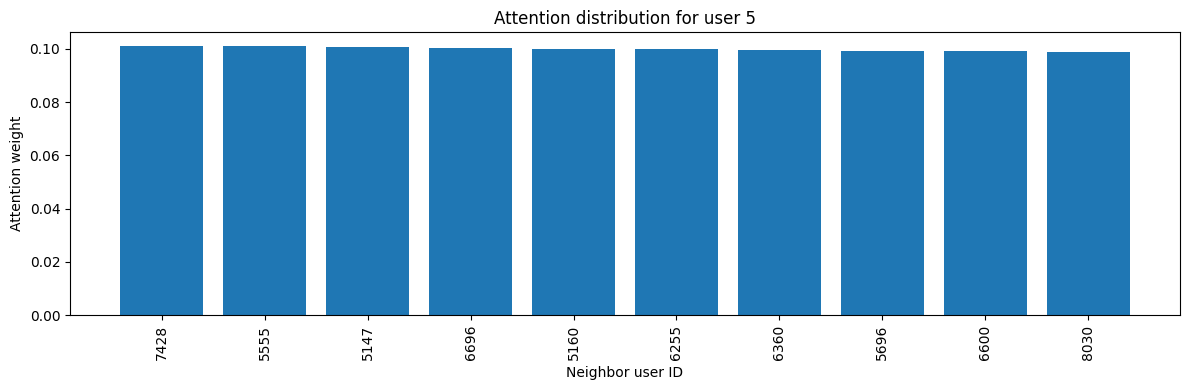

Top neighbors: [7428 5555 5147 6696 5160]
Top weights: [0.10116672 0.10110646 0.10066896 0.10041114 0.0999713 ]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

u = 5

with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)

# extract COO edge list
idx = A_denoised_torch.coalesce().indices()   # shape [2, E]
rows = idx[0]
cols = idx[1]

# edges originating from user u
mask = (rows == u)

if mask.sum() == 0:
    print(f"User {u} has no neighbors in A'")
else:
    neighbor_ids = cols[mask].cpu().numpy()
    neighbor_weights = attn[mask].detach().cpu().numpy()

    # sort neighbors by descending weight
    order = neighbor_weights.argsort()[::-1]
    neighbor_ids = neighbor_ids[order]
    neighbor_weights = neighbor_weights[order]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(neighbor_ids)), neighbor_weights)
    plt.xticks(range(len(neighbor_ids)), neighbor_ids, rotation=90)
    plt.title(f"Attention distribution for user {u}")
    plt.xlabel("Neighbor user ID")
    plt.ylabel("Attention weight")
    plt.tight_layout()
    plt.show()

    print("Top neighbors:", neighbor_ids[:5])
    print("Top weights:", neighbor_weights[:5])


In [ ]:
def explain_recommendation(user_id, item_id, model, A_sparse, attention_vec, top_k_social=5):
    """
    Explanation for why a recommendation (user → item) was made.
    Includes:
       - top social influencers (GAT attention)
       - user-item interaction score
    """
    # -----------------------------
    # 1. Social influencer extraction
    # -----------------------------
    top_neighbors, top_weights = explain_social_influence(
        user_id=user_id,
        attn=attention_vec,
        A_sparse=A_sparse,
        top_k=top_k_social
    )

    social_msgs = [
        f"Friend {int(n)} influenced this recommendation with attention weight {float(w):.4f}"
        for n, w in zip(top_neighbors, top_weights)
    ]

    # -----------------------------
    # 2. User–item embedding score
    # -----------------------------
    with torch.no_grad():
        user_z, _ = model.propagate_users(A_sparse)
        u_vec = user_z[user_id]
        i_vec = model.item_emb(torch.tensor([item_id], device=u_vec.device)).squeeze(0)
        dot_score = float(torch.dot(u_vec, i_vec).cpu())

    interaction_msg = f"User–item embedding dot product score = {dot_score:.4f}"

    return {
        "social_explanations": social_msgs,
        "interaction_explanation": interaction_msg
    }


In [ ]:
with torch.no_grad():
    _, attention_vec = explain_model.propagate_users(A_denoised_torch)


In [ ]:
explanation = explain_recommendation(
    user_id=5,
    item_id=20,
    model=explain_model,
    A_sparse=A_denoised_torch,      # correct name
    attention_vec=attention_vec     # required!
)

explanation


{'social_explanations': ['Friend 7428 influenced this recommendation with attention weight 0.1012',
  'Friend 5555 influenced this recommendation with attention weight 0.1011',
  'Friend 5147 influenced this recommendation with attention weight 0.1007',
  'Friend 6696 influenced this recommendation with attention weight 0.1004',
  'Friend 5160 influenced this recommendation with attention weight 0.1000'],
 'interaction_explanation': 'User–item embedding dot product score = -0.0000'}

In [ ]:
def fidelity_test(user, item, model, A_sparse, attn):
    # -------------------------------
    # 1. Compute original score
    # -------------------------------
    with torch.no_grad():
        score_original, _ = model.forward(
            torch.tensor([user], device=device),
            torch.tensor([item], device=device),
            A_sparse=A_sparse
        )

    # -------------------------------
    # 2. Get COO edges
    # -------------------------------
    idx = A_sparse.coalesce().indices()
    rows = idx[0]
    cols = idx[1]

    # edges originating at this user
    mask = (rows == user)
    if mask.sum() == 0:
        return 0.0     # user has no neighbors

    user_edges = attn[mask]                 # attention for edges from user
    neighbors = cols[mask]                  # neighbor user IDs

    # find the most influential neighbor
    top_edge_idx = user_edges.argmax().item()
    top_neighbor = neighbors[top_edge_idx].item()

    # -------------------------------
    # 3. Build new adjacency without this edge
    # -------------------------------
    # We build a filtered adjacency by removing this one edge
    remove_mask = ~((rows == user) & (cols == top_neighbor))

    new_rows = rows[remove_mask]
    new_cols = cols[remove_mask]
    new_vals = A_sparse.coalesce().values()[remove_mask]

    A_new = torch.sparse_coo_tensor(
        torch.vstack([new_rows, new_cols]),
        new_vals,
        A_sparse.size()
    ).coalesce().to(device)

    # -------------------------------
    # 4. Compute new score
    # -------------------------------
    with torch.no_grad():
        score_removed, _ = model.forward(
            torch.tensor([user], device=device),
            torch.tensor([item], device=device),
            A_sparse=A_new
        )

    # return absolute change
    return float(abs(score_original - score_removed))


In [ ]:
with torch.no_grad():
    _, attn = explain_model.propagate_users(A_denoised_torch)

fidelity = fidelity_test(5, 20, explain_model, A_denoised_torch, attn)
print("Fidelity:", fidelity)


Fidelity: 4.4602766138268635e-06


STEP 2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MFBaseline(nn.Module):
    """
    Simple Matrix Factorization:
    - user_emb: [num_users, d]
    - item_emb: [num_items, d]
    Forward signature matches SocialGCN: (user_idx, item_idx) -> (logits, _)
    """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_idx, item_idx):
        u = self.user_emb(user_idx)        # [B, d]
        i = self.item_emb(item_idx)        # [B, d]
        logits = (u * i).sum(dim=1)        # dot product
        logits += self.user_bias(user_idx).squeeze(1)
        logits += self.item_bias(item_idx).squeeze(1)
        return logits, None  # dummy second output


In [ ]:
# Initialize MF model
emb_dim = 64
mf_model = MFBaseline(num_users, num_items, emb_dim).to(device)

optimizer_mf = optim.Adam(mf_model.parameters(), lr=0.005)
criterion_mf = nn.MSELoss()      # predict normalized rating in [0,1]

print("MF baseline initialized.")


MF baseline initialized.


In [ ]:
def train_mf_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_count = 0.0, 0

    for u, i, r in loader:
        u = u.to(device)
        i = i.to(device)
        r = r.to(device)

        optimizer.zero_grad()
        logits, _ = model(u, i)

        preds = torch.sigmoid(logits)   # normalize to [0,1]
        loss = criterion_mf(preds, r)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(u)
        total_count += len(u)

    return total_loss / total_count


num_epochs_mf = 10   # MF converges fast

for epoch in range(1, num_epochs_mf + 1):
    loss = train_mf_epoch(mf_model, train_loader, optimizer_mf)
    print(f"[MF Epoch {epoch:02d}] train_loss = {loss:.4f}")


[MF Epoch 01] train_loss = 0.0633
[MF Epoch 02] train_loss = 0.0099
[MF Epoch 03] train_loss = 0.0024
[MF Epoch 04] train_loss = 0.0014
[MF Epoch 05] train_loss = 0.0010
[MF Epoch 06] train_loss = 0.0008
[MF Epoch 07] train_loss = 0.0007
[MF Epoch 08] train_loss = 0.0006
[MF Epoch 09] train_loss = 0.0006
[MF Epoch 10] train_loss = 0.0006


In [ ]:
with torch.no_grad():
    mf_user_emb = mf_model.user_emb.weight.detach().cpu().numpy()
    mf_item_emb = mf_model.item_emb.weight.detach().cpu().numpy()

print("MF user embeddings:", mf_user_emb.shape)
print("MF item embeddings:", mf_item_emb.shape)


MF user embeddings: (22164, 64)
MF item embeddings: (296277, 64)


In [ ]:
def get_mf_user_scores(user_id):
    u = mf_user_emb[user_id]              # (d,)
    scores = mf_item_emb @ u              # dot product
    return 1 / (1 + np.exp(-scores))      # sigmoid


In [ ]:
print("=== MF Baseline Validation ===")
p_val, r_val, n_val = evaluate_split(
    val_inter,
    seen_train,
    k=10,
    rating_thresh=0.5,
    max_users=500,
)
print(f"P@10={p_val:.4f}, R@10={r_val:.4f}, nDCG@10={n_val:.4f}")

print("\n=== MF Baseline Test ===")
p_test, r_test, n_test = evaluate_split(
    test_inter,
    seen_trainval,
    k=10,
    rating_thresh=0.5,
    max_users=500,
)
print(f"P@10={p_test:.4f}, R@10={r_test:.4f}, nDCG@10={n_test:.4f}")


=== MF Baseline Validation ===
P@10=0.0026, R@10=0.0092, nDCG@10=0.0126

=== MF Baseline Test ===
P@10=0.0036, R@10=0.0145, nDCG@10=0.0151


In [ ]:
res_mf = {
    "model": "MF_baseline",
    "val_P@10": p_val,
    "val_R@10": r_val,
    "val_nDCG@10": n_val,
    "test_P@10": p_test,
    "test_R@10": r_test,
    "test_nDCG@10": n_test,
}

res_mf

{'model': 'MF_baseline',
 'val_P@10': 0.0026,
 'val_R@10': 0.009218518518518518,
 'val_nDCG@10': 0.012584420035292535,
 'test_P@10': 0.0036,
 'test_R@10': 0.014529679802955664,
 'test_nDCG@10': 0.015113044656386746}

In [ ]:
# SocialGCN WITHOUT denoising: uses original A_norm_torch
emb_dim = 64

social_gcn_raw = SocialGCN(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    adj=A_norm_torch,     # <<< original adjacency
    alpha=0.6,
    dropout_p=0.25
).to(device)

gcn_raw_optimizer = optim.Adam(social_gcn_raw.parameters(), lr=0.005)

num_epochs_gnn_raw = 20
n_neg = 5
mse_lambda = 0.1

for epoch in range(1, num_epochs_gnn_raw + 1):
    train_loss = run_train_epoch_multi_bpr(
        social_gcn_raw,
        train_loader,
        gcn_raw_optimizer,
        n_neg=n_neg,
        mse_lambda=mse_lambda,
    )
    print(f"[GCN-RAW Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("SocialGCN (raw adjacency) training complete.")


[GCN-RAW Epoch 01] train_loss = 0.6030
[GCN-RAW Epoch 02] train_loss = 0.4558
[GCN-RAW Epoch 03] train_loss = 0.3879
[GCN-RAW Epoch 04] train_loss = 0.3398
[GCN-RAW Epoch 05] train_loss = 0.2948
[GCN-RAW Epoch 06] train_loss = 0.2484
[GCN-RAW Epoch 07] train_loss = 0.2089
[GCN-RAW Epoch 08] train_loss = 0.1751
[GCN-RAW Epoch 09] train_loss = 0.1480
[GCN-RAW Epoch 10] train_loss = 0.1265
[GCN-RAW Epoch 11] train_loss = 0.1102
[GCN-RAW Epoch 12] train_loss = 0.0972
[GCN-RAW Epoch 13] train_loss = 0.0872
[GCN-RAW Epoch 14] train_loss = 0.0791
[GCN-RAW Epoch 15] train_loss = 0.0722
[GCN-RAW Epoch 16] train_loss = 0.0672
[GCN-RAW Epoch 17] train_loss = 0.0626
[GCN-RAW Epoch 18] train_loss = 0.0590
[GCN-RAW Epoch 19] train_loss = 0.0557
[GCN-RAW Epoch 20] train_loss = 0.0529
SocialGCN (raw adjacency) training complete.


In [ ]:
def set_embeddings_from_numpy(U, I):
    """
    Store user/item embeddings globally so that:
    - get_user_scores()
    - recommend_for_user_eval()
    - evaluate_split()
    use the correct embeddings for each model.
    """
    global user_embeddings, item_embeddings
    user_embeddings = U
    item_embeddings = I


In [ ]:
set_embeddings_from_numpy(U_raw, I_raw)


In [ ]:
def evaluate_model_label(label, seen_train, seen_trainval, K=10):
    """
    Evaluate a model using the *current* global user_embeddings and item_embeddings.
    Returns a dictionary of Val/Test metrics.
    """
    # Validation metrics
    p_val, r_val, n_val = evaluate_split(
        val_inter,
        seen_train,
        k=K,
        rating_thresh=0.5,
        max_users=500,
    )

    # Test metrics
    p_test, r_test, n_test = evaluate_split(
        test_inter,
        seen_trainval,
        k=K,
        rating_thresh=0.5,
        max_users=500,
    )

    return {
        "model": label,
        f"val_P@{K}": p_val,
        f"val_R@{K}": r_val,
        f"val_nDCG@{K}": n_val,
        f"test_P@{K}": p_test,
        f"test_R@{K}": r_test,
        f"test_nDCG@{K}": n_test,
    }


In [ ]:
res_raw = evaluate_model_label(
    "SocialGCN_raw",
    seen_train,
    seen_trainval,
    K=10
)

res_raw



===== Evaluating SocialGCN_raw =====
[VAL ]  P@10: 0.0026 | R@10: 0.0091 | nDCG@10: 0.0100
[TEST]  P@10: 0.0032 | R@10: 0.0086 | nDCG@10: 0.0142


{'model': 'SocialGCN_raw',
 'val_P@10': 0.0026,
 'val_R@10': 0.009110938578329883,
 'val_nDCG@10': 0.009984135458221879,
 'test_P@10': 0.0032,
 'test_R@10': 0.008585352269562795,
 'test_nDCG@10': 0.014175212457565074}

In [ ]:
# ============================
# SocialGCN WITH Denoising (A')
# ============================

emb_dim = 64

social_gcn_denoised = SocialGCN(
    num_users=num_users,
    num_items=num_items,
    emb_dim=emb_dim,
    adj=A_denoised_norm_torch,   # <<< EPINIONS: USE NORMALIZED DENOISED ADJ
    alpha=0.6,
    dropout_p=0.25
).to(device)

gcn_denoised_optimizer = optim.Adam(social_gcn_denoised.parameters(), lr=0.005)

num_epochs_gnn_denoised = 20
n_neg = 5
mse_lambda = 0.1

for epoch in range(1, num_epochs_gnn_denoised + 1):
    train_loss = run_train_epoch_multi_bpr(
        social_gcn_denoised,
        train_loader,
        gcn_denoised_optimizer,
        n_neg=n_neg,
        mse_lambda=mse_lambda,
    )
    print(f"[GCN-DENOISED Epoch {epoch:02d}] train_loss = {train_loss:.4f}")

print("SocialGCN (denoised adjacency) training complete.")


[GCN-DENOISED Epoch 01] train_loss = 0.6042
[GCN-DENOISED Epoch 02] train_loss = 0.4557
[GCN-DENOISED Epoch 03] train_loss = 0.3880
[GCN-DENOISED Epoch 04] train_loss = 0.3387
[GCN-DENOISED Epoch 05] train_loss = 0.2896
[GCN-DENOISED Epoch 06] train_loss = 0.2379
[GCN-DENOISED Epoch 07] train_loss = 0.1956
[GCN-DENOISED Epoch 08] train_loss = 0.1635
[GCN-DENOISED Epoch 09] train_loss = 0.1394
[GCN-DENOISED Epoch 10] train_loss = 0.1212
[GCN-DENOISED Epoch 11] train_loss = 0.1069
[GCN-DENOISED Epoch 12] train_loss = 0.0957
[GCN-DENOISED Epoch 13] train_loss = 0.0867
[GCN-DENOISED Epoch 14] train_loss = 0.0794
[GCN-DENOISED Epoch 15] train_loss = 0.0734
[GCN-DENOISED Epoch 16] train_loss = 0.0686
[GCN-DENOISED Epoch 17] train_loss = 0.0641
[GCN-DENOISED Epoch 18] train_loss = 0.0608
[GCN-DENOISED Epoch 19] train_loss = 0.0573
[GCN-DENOISED Epoch 20] train_loss = 0.0547
SocialGCN (denoised adjacency) training complete.


In [ ]:
# -------------------------------------------
# STEP 1: Extract embeddings for evaluation
# -------------------------------------------
social_gcn_denoised.eval()
with torch.no_grad():
    U_denoised = social_gcn_denoised.propagate_users().cpu().numpy()
    I_denoised = social_gcn_denoised.item_emb.weight.detach().cpu().numpy()

print("Denoised user embedding shape:", U_denoised.shape)
print("Denoised item embedding shape:", I_denoised.shape)


Denoised user embedding shape: (22164, 64)
Denoised item embedding shape: (296277, 64)


In [ ]:
# -------------------------------------------
# STEP 2: Set global embeddings
# -------------------------------------------
set_embeddings_from_numpy(U_denoised, I_denoised)


In [ ]:
def evaluate_model_label(label, seen_train, seen_trainval, K=10):
    """
    Evaluate the CURRENT ACTIVE MODEL using global user_embeddings & item_embeddings.
    Computes metrics on:
        - Validation set (excluding only train interactions)
        - Test set       (excluding train + val interactions)

    Returns a dictionary for easy aggregation into comparison tables.
    """

    print(f"\n================ {label} =================")

    # ---------- Validation ----------
    p_val, r_val, ndcg_val = evaluate_split(
        interactions=val_inter,
        seen_dict=seen_train,
        k=K,
        rating_thresh=0.5,
        max_users=500
    )

    # ---------- Test ----------
    p_test, r_test, ndcg_test = evaluate_split(
        interactions=test_inter,
        seen_dict=seen_trainval,
        k=K,
        rating_thresh=0.5,
        max_users=500
    )

    # ---------- Clean console output ----------
    print(f"[VAL ]  P@{K}: {p_val:.4f} | R@{K}: {r_val:.4f} | nDCG@{K}: {ndcg_val:.4f}")
    print(f"[TEST]  P@{K}: {p_test:.4f} | R@{K}: {r_test:.4f} | nDCG@{K}: {ndcg_test:.4f}")

    # ---------- Return structured record ----------
    return {
        "model": label,
        f"val_P@{K}": p_val,
        f"val_R@{K}": r_val,
        f"val_nDCG@{K}": ndcg_val,
        f"test_P@{K}": p_test,
        f"test_R@{K}": r_test,
        f"test_nDCG@{K}": ndcg_test
    }


In [ ]:
# ============================================
# Evaluate SocialGCN WITH denoising (A')
# ============================================
res_denoised = evaluate_model_label(
    label="SocialGCN_denoised",
    seen_train=seen_train,
    seen_trainval=seen_trainval,
    K=10
)

res_denoised



================ SocialGCN_denoised =================
[VAL ]  P@10: 0.0024 | R@10: 0.0067 | nDCG@10: 0.0116
[TEST]  P@10: 0.0044 | R@10: 0.0086 | nDCG@10: 0.0183


{'model': 'SocialGCN_denoised',
 'val_P@10': 0.0024000000000000002,
 'val_R@10': 0.006737179487179487,
 'val_nDCG@10': 0.01159522782520222,
 'test_P@10': 0.0044,
 'test_R@10': 0.008617785337771727,
 'test_nDCG@10': 0.01831464017202379}

In [ ]:
import pandas as pd

# Combine all model results in consistent order
comparison_df = pd.DataFrame([
    res_mf,
    res_raw,
    res_denoised
])

# Reorder columns for clarity
ordered_cols = [
    "model",
    "val_P@10", "val_R@10", "val_nDCG@10",
    "test_P@10", "test_R@10", "test_nDCG@10"
]

comparison_df = comparison_df[ordered_cols]

comparison_df


,model,val_P@10,val_R@10,val_nDCG@10,test_P@10,test_R@10,test_nDCG@10
0,MF_baseline,0.0026,0.009219,0.012584,0.0036,0.014530,0.015113
1,SocialGCN_raw,0.0026,0.009111,0.009984,0.0032,0.008585,0.014175
2,SocialGCN_denoised,0.0024,0.006737,0.011595,0.0044,0.008618,0.018315


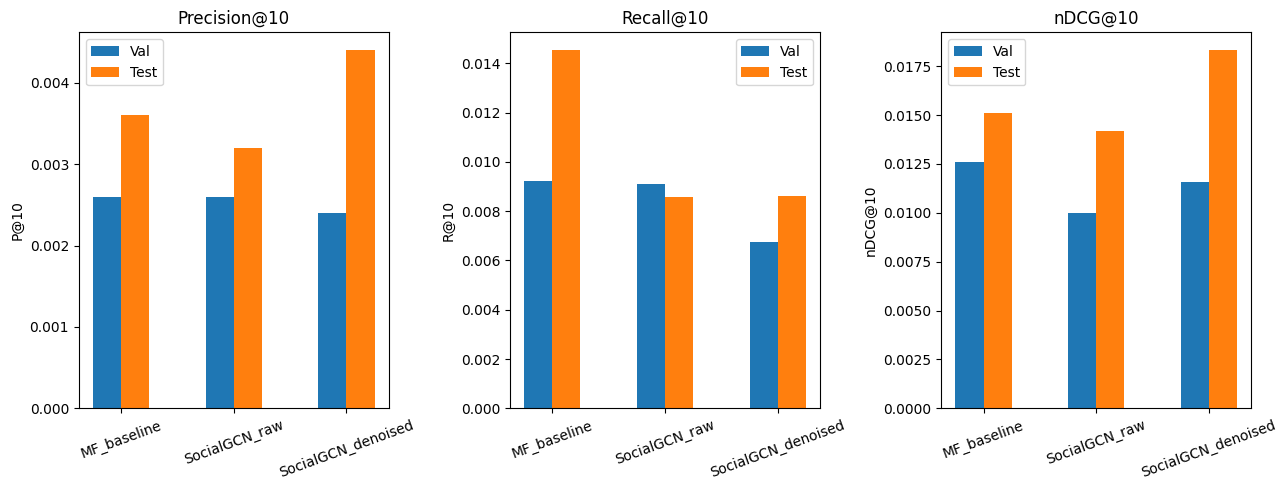

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_bar(comparison_df):
    models = comparison_df["model"].tolist()
    x = np.arange(len(models))
    width = 0.25

    # Extract correct metric columns
    val_P = comparison_df["val_P@10"].tolist()
    val_R = comparison_df["val_R@10"].tolist()
    val_nD = comparison_df["val_nDCG@10"].tolist()

    test_P = comparison_df["test_P@10"].tolist()
    test_R = comparison_df["test_R@10"].tolist()
    test_nD = comparison_df["test_nDCG@10"].tolist()

    plt.figure(figsize=(13, 5))

    # ------ Precision ------
    plt.subplot(1, 3, 1)
    plt.bar(x - width/2, val_P, width, label='Val')
    plt.bar(x + width/2, test_P, width, label='Test')
    plt.xticks(x, models, rotation=20)
    plt.title("Precision@10")
    plt.ylabel("P@10")
    plt.legend()

    # ------ Recall ------
    plt.subplot(1, 3, 2)
    plt.bar(x - width/2, val_R, width, label='Val')
    plt.bar(x + width/2, test_R, width, label='Test')
    plt.xticks(x, models, rotation=20)
    plt.title("Recall@10")
    plt.ylabel("R@10")
    plt.legend()

    # ------ nDCG ------
    plt.subplot(1, 3, 3)
    plt.bar(x - width/2, val_nD, width, label='Val')
    plt.bar(x + width/2, test_nD, width, label='Test')
    plt.xticks(x, models, rotation=20)
    plt.title("nDCG@10")
    plt.ylabel("nDCG@10")
    plt.legend()

    plt.tight_layout()
    plt.show()

# RUN IT
plot_comparison_bar(comparison_df)


2.3


In [ ]:
target_user = 100  # pick any user id


In [ ]:
# Convert adjacency row to dense CPU array
A_dense = A_norm_torch.to_dense().cpu().numpy()
neighbors = np.where(A_dense[target_user] > 0)[0]
neighbors


array([  1,  11, 100, 125, 187, 351, 390, 445, 476, 512, 550, 567, 580,
       588, 655, 675, 770, 931, 932, 933])

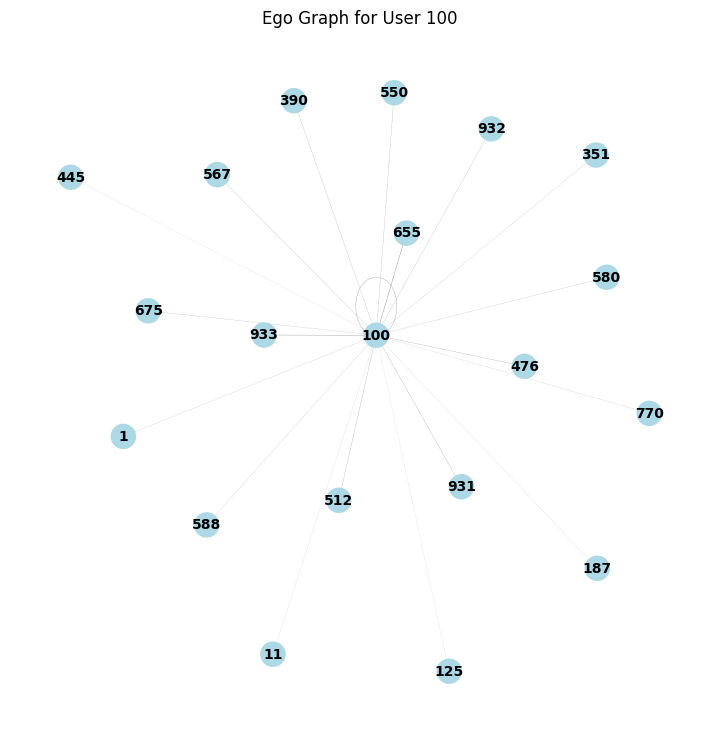

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create ego graph
G = nx.Graph()

# Add target user
G.add_node(target_user, color='red', size=500)

# Add neighbors + edges
for nb in neighbors:
    G.add_node(nb, color='lightblue', size=300)
    weight = A_dense[target_user, nb]
    G.add_edge(target_user, nb, weight=weight)

# Extract attributes
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
edge_weights = [G[u][v]['weight']*4 for u,v in G.edges()]  # scale for visibility

# Draw
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, seed=1)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    width=edge_weights,
    edge_color='gray',
    font_size=10,
    font_weight='bold'
)
plt.title(f"Ego Graph for User {target_user}")
plt.show()


In [ ]:
target_user = 10  # pick any user id

In [ ]:
# Convert adjacency row to dense CPU array
A_dense = A_norm_torch.to_dense().cpu().numpy()
neighbors = np.where(A_dense[target_user] > 0)[0]
neighbors


array([  0,   1,   6,   8,   9,  10,  11,  14,  17,  21,  23,  26,  28,
        32,  34,  36,  41,  45,  46,  54,  62,  69,  70,  73,  74,  76,
        79,  83,  85,  87,  89,  92,  96, 102, 104, 109, 117, 119, 123,
       125, 128, 132, 136, 141, 143, 145, 147, 148, 149, 152, 153, 154,
       158, 159, 162, 163, 166, 167, 168, 174, 176, 177, 181, 184, 185,
       187, 188, 189, 191, 194, 202, 203, 217, 227, 229, 230, 238, 240,
       241, 250, 254, 257, 258, 259, 261, 263, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 333, 363, 364,
       380, 382, 426, 436, 438, 445, 446, 457, 461, 502, 507, 566, 625,
       673, 690, 757])

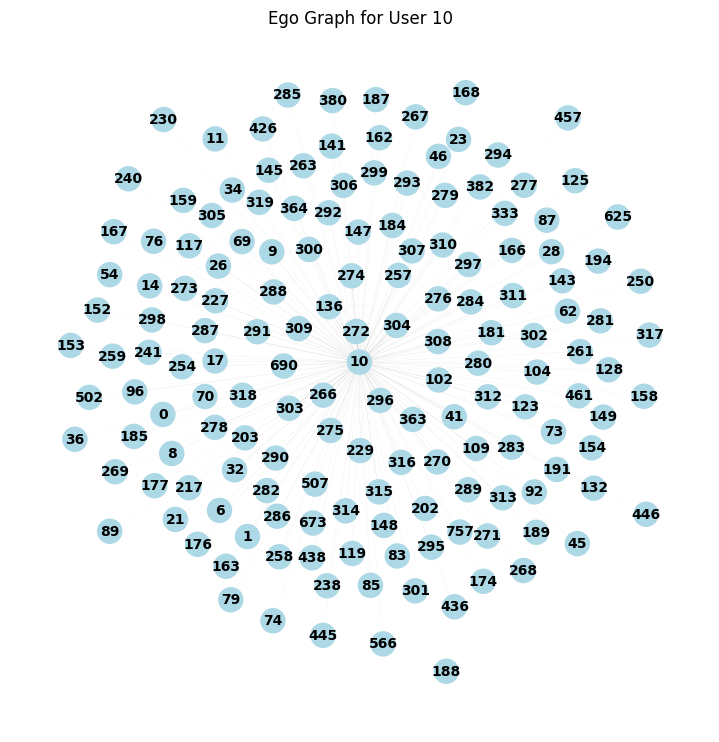

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create ego graph
G = nx.Graph()

# Add target user
G.add_node(target_user, color='red', size=500)

# Add neighbors + edges
for nb in neighbors:
    G.add_node(nb, color='lightblue', size=300)
    weight = A_dense[target_user, nb]
    G.add_edge(target_user, nb, weight=weight)

# Extract attributes
node_colors = [G.nodes[n]['color'] for n in G.nodes()]
node_sizes = [G.nodes[n]['size'] for n in G.nodes()]
edge_weights = [G[u][v]['weight']*4 for u,v in G.edges()]  # scale for visibility

# Draw
plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, seed=1)
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    width=edge_weights,
    edge_color='gray',
    font_size=10,
    font_weight='bold'
)
plt.title(f"Ego Graph for User {target_user}")
plt.show()

In [ ]:
import torch
import numpy as np

def explain_recommendations_for_user(model, user_id, top_k=10, top_dims=5):
    model.eval()

    # 1. Propagate user embeddings (GCN)
    with torch.no_grad():
        U = model.propagate_users()       # FIXED: only one return
        U = U.cpu()
        I = model.item_emb.weight.detach().cpu()

    # 2. Compute scores
    user_vec = U[user_id]
    scores = (user_vec * I).sum(dim=1)
    top_items = torch.topk(scores, top_k).indices.tolist()

    # 3. Social influence from adjacency
    A_norm = model.adj.cpu()
    neighbors = torch.where(A_norm[user_id] > 0)[0].tolist()
    neighbor_weights = A_norm[user_id, neighbors].numpy()

    neigh_sorted = sorted(
        zip(neighbors, neighbor_weights),
        key=lambda x: x[1],
        reverse=True
    )

    # 4. Explanations
    explanations = []
    for item in top_items:
        item_vec = I[item]

        # Feature contributions
        dim_importance = torch.abs(user_vec * item_vec).numpy()
        top_dims_idx = dim_importance.argsort()[-top_dims:][::-1]

        feature_expls = [
            f"Embedding dimension {int(d)} contributed {dim_importance[d]:.4f}"
            for d in top_dims_idx
        ]

        # Social contributions
        social_expls = [
            f"Friend {int(n)} influenced this recommendation with weight {float(w):.4f}"
            for n, w in neigh_sorted[:5]
        ]

        explanations.append({
            "item_id": int(item),
            "score": float(scores[item]),
            "social_explanations": social_expls,
            "feature_explanations": feature_expls
        })

    return explanations


# ---- RUN ----
USER = 57

explanations = explain_recommendations_for_user(
    social_gcn_denoised,
    USER,
    top_k=10,
    top_dims=5
)

explanations


[{'item_id': 1818,
  'score': 7.046016216278076,
  'social_explanations': ['Friend 167 influenced this recommendation with weight 0.1902',
   'Friend 149 influenced this recommendation with weight 0.1765',
   'Friend 132 influenced this recommendation with weight 0.1765',
   'Friend 162 influenced this recommendation with weight 0.1739',
   'Friend 163 influenced this recommendation with weight 0.1724'],
  'feature_explanations': ['Embedding dimension 25 contributed 0.7133',
   'Embedding dimension 46 contributed 0.5829',
   'Embedding dimension 49 contributed 0.4178',
   'Embedding dimension 8 contributed 0.4007',
   'Embedding dimension 50 contributed 0.3211']},
 {'item_id': 2258,
  'score': 7.0020952224731445,
  'social_explanations': ['Friend 167 influenced this recommendation with weight 0.1902',
   'Friend 149 influenced this recommendation with weight 0.1765',
   'Friend 132 influenced this recommendation with weight 0.1765',
   'Friend 162 influenced this recommendation with we

In [ ]:
import pandas as pd
import re

def extract_friend_ids(social_list):
    """
    Converts:
    ["Friend 167 influenced...", "Friend 149 influenced..."]
    into:
    "167, 149"
    """
    ids = []
    for text in social_list:
        # Extract number after 'Friend '
        match = re.search(r"Friend\s+(\d+)", text)
        if match:
            ids.append(match.group(1))
    return ", ".join(ids)


def explanations_to_table_short(explanations):
    rows = []
    for e in explanations:
        friend_ids = extract_friend_ids(e["social_explanations"])

        rows.append({
            "Item ID": e["item_id"],
            "Score": round(e["score"], 4),
            "Top Friends": friend_ids,   # only friend numbers
            "Top Feature Dims": ", ".join([
                f"{dim.split()[2]}"      # Extract the dimension number
                for dim in e["feature_explanations"]
            ])
        })
    return pd.DataFrame(rows)

# RUN
clean_table = explanations_to_table_short(explanations)
clean_table


,Item ID,Score,Top Social Influencers,Top Feature Contributions
0,1818,7.0460,Friend 167 influenced this recommendation with...,Embedding dimension 25 contributed 0.7133\nEmb...
1,2258,7.0021,Friend 167 influenced this recommendation with...,Embedding dimension 25 contributed 0.8336\nEmb...
2,2136,6.8433,Friend 167 influenced this recommendation with...,Embedding dimension 8 contributed 0.6049\nEmbe...
3,8544,6.7925,Friend 167 influenced this recommendation with...,Embedding dimension 49 contributed 0.7333\nEmb...
4,2975,6.7766,Friend 167 influenced this recommendation with...,Embedding dimension 49 contributed 0.7682\nEmb...
5,267,6.7088,Friend 167 influenced this recommendation with...,Embedding dimension 8 contributed 0.5779\nEmbe...
6,298,6.5474,Friend 167 influenced this recommendation with...,Embedding dimension 25 contributed 0.6383\nEmb...
7,3795,6.5412,Friend 167 influenced this recommendation with...,Embedding dimension 49 contributed 0.5066\nEmb...
8,1898,6.4380,Friend 167 influenced this recommendation with...,Embedding dimension 25 contributed 0.7221\nEmb...
9,485,6.4372,Friend 167 influenced this recommendation with...,Embedding dimension 25 contributed 0.7809\nEmb...


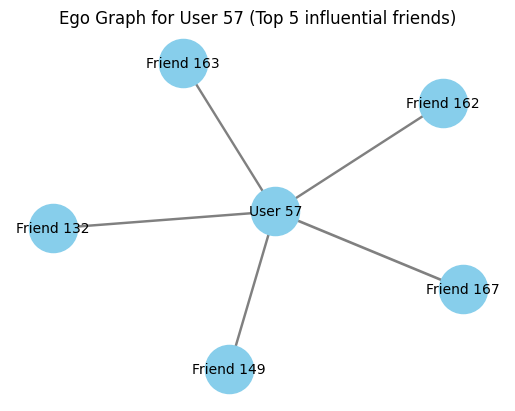

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def plot_ego_graph(model, user_id, top_n=5):
    """
    Builds and plots an ego-graph:
    - Center node = target user
    - Neighbor nodes = top-N influential neighbors
    - Edge width ∝ social influence weight (adjacency)
    """

    # Move adjacency to CPU
    A = model.adj.cpu()

    # Find all neighbors of this user
    neighbors = torch.where(A[user_id] > 0)[0].tolist()
    weights = A[user_id, neighbors].numpy()

    # Sort neighbors by influence
    neigh_sorted = sorted(zip(neighbors, weights),
                          key=lambda x: x[1],
                          reverse=True)

    # Take top-N neighbors
    top_neighbors = neigh_sorted[:top_n]

    # Build graph
    G = nx.Graph()
    G.add_node(user_id)

    for n, w in top_neighbors:
        G.add_node(int(n))
        G.add_edge(user_id, int(n), weight=float(w))

    # Prepare layout
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                           node_color="skyblue",
                           node_size=1200)

    # Draw labels
    labels = {user_id: f"User {user_id}"}
    for n, _ in top_neighbors:
        labels[int(n)] = f"Friend {n}"

    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Draw edges with width proportional to influence
    edges = G.edges()
    edge_weights = [G[u][v]['weight'] * 10 for u, v in edges]  # scaled for visibility

    nx.draw_networkx_edges(G, pos,
                           width=edge_weights,
                           edge_color="gray")

    # Title
    plt.title(f"Ego Graph for User {user_id} (Top {top_n} influential friends)")
    plt.axis("off")
    plt.show()


# ---- RUN ----
plot_ego_graph(social_gcn_denoised, user_id=57, top_n=5)
